In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import ParameterGrid

In [2]:
df = pd.read_csv('final_combined_dataset.csv')


In [3]:
from sklearn.preprocessing import LabelEncoder


df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

df["year_sin"] = np.sin(2 * np.pi * df["year"] / df["year"].max())
df["year_cos"] = np.cos(2 * np.pi * df["year"] / df["year"].max())

# df["cases_rolling_mean"] = df.groupby("geocode")["cases"].transform(lambda x: x.rolling(4).mean())


# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[0,1,-2])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(df, group_col='city', target_col=weather_columns, lags=[3,4])
data = data.dropna().reset_index(drop=True)


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(sparse_output=False), ['geocode'])  # One-hot encode 'geocode'
], remainder='passthrough')  # Keep all other columns as is

transformed_data = ct.fit_transform(data)

# Get feature names
feature_names = ct.get_feature_names_out()

# Clean feature names to remove 'remainder__' prefix
cleaned_feature_names = [name.split('__')[-1] if 'remainder__' in name else name for name in feature_names]

# Convert transformed data back to DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=cleaned_feature_names)

numeric_cols = data.select_dtypes(include=['float64', 'int64','int32']).columns
for col in numeric_cols:
    if col in transformed_df.columns:
        transformed_df[col] = pd.to_numeric(transformed_df[col], errors='coerce')

if 'date' in transformed_df.columns:
    transformed_df['date'] = pd.to_datetime(transformed_df['date'], errors='coerce')

data= transformed_df

# Now 'transformed_df' contains the transformed data with the correct types
train_data = data[data['date'].dt.year <= 2018]
test_data = data[data['date'].dt.year >= 2019]
pd.set_option('display.max_columns', None)
train_data.info

<bound method DataFrame.info of       onehot__geocode_3300100 onehot__geocode_3300159 onehot__geocode_3300209  \
0                         1.0                     0.0                     0.0   
1                         1.0                     0.0                     0.0   
2                         1.0                     0.0                     0.0   
3                         1.0                     0.0                     0.0   
4                         1.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51477                     0.0                     0.0                     0.0   
51478                     0.0                     0.0                     0.0   
51479                     0.0                     0.0                     0.0   
51480                     0.0                     0.0                     0.0   
51481                     0.0                     0.0                     0.0

In [4]:
X_train = train_data.drop(columns=['cases','cases_lag-2'])
y_train = train_data[['cases_lag-2']]

X_test = test_data.drop(columns=['cases','cases_lag-2'])
y_test = test_data[['cases_lag-2']]

data = data.drop(columns=['cases_per_100k'])

data

onehot__geocode_3300100 onehot__geocode_3300159 onehot__geocode_3300209  \
0                         1.0                     0.0                     0.0   
1                         1.0                     0.0                     0.0   
2                         1.0                     0.0                     0.0   
3                         1.0                     0.0                     0.0   
4                         1.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300225 onehot__geocode_3300233 onehot__geocode_3300258  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300308 onehot__geocode_3300407 onehot__geocode_3300456  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300506 onehot__geocode_3300605 onehot__geocode_3300704  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300803 onehot__geocode_3300902 onehot__geocode_3300936  \
0                         0.0    

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV

# Step 1-6: Keep the previous preprocessing steps the same (data preparation, scaling, etc.)
columns_not_to_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'week', 'lat', 'long', 
                    'geocode', 'year_sin', 'year_cos'] + [col for col in data.columns if col.startswith('onehot__geocode_')]

feature_cols = [
    'cases_lag0', 'cases_lag1',
    'temp_avg', 'humidity_avg',
    'precipitation_avg_ordinary_kriging_lag3',
    'precipitation_avg_ordinary_kriging_lag4',
    'week_sin', 'month_sin', 'week_cos', 'month_cos',
    'week','cases_per_100k','vim'
]


selected_columns = feature_cols + [col for col in data.columns if col.startswith('onehot_')]

X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

numeric_features = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64', 'float32', 'int32'] 
                   and col not in columns_not_to_scale]

X_train[numeric_features] = feature_scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = feature_scaler.transform(X_test[numeric_features])

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

y_train_scaled = target_scaler.fit_transform(y_train_reshaped).ravel()
y_test_scaled = target_scaler.transform(y_test_reshaped).ravel()

X_train

cases_lag0  cases_lag1  temp_avg  humidity_avg  \
0        0.002448    0.002244  0.754745      0.201372   
1        0.002652    0.002448  0.873856      0.081175   
2        0.002516    0.002652  0.745730      0.297196   
3        0.002244    0.002516  0.812070      0.210681   
4        0.003128    0.002244  0.886925      0.085515   
...           ...         ...       ...           ...   
51477    0.000272    0.000612  0.615720      0.777955   
51478    0.000544    0.000272  0.678529      0.691676   
51479    0.000408    0.000544  0.674939      0.664207   
51480    0.000476    0.000408  0.683580      0.744315   
51481    0.000340    0.000476  0.737697      0.717031   

       precipitation_avg_ordinary_kriging_lag3  \
0                                     0.354975   
1                                     0.179205   
2                                     0.134402   
3                                     0.245891   
4                                     0.332778   
...                                        ...   
51477                                 0.093426   
51478                                 0.228272   
51479                                 0.204558   
51480                                 0.220495   
51481                                 0.033295   

       precipitation_avg_ordinary_kriging_lag4  week_sin     month_sin  \
0                                     0.495235  0.885456  5.000000e-01   
1                                     0.354975  0.822984  8.660254e-01   
2                                     0.179205  0.748511  8.660254e-01   
3                                     0.134402  0.663123  8.660254e-01   
4                                     0.245891  0.568065  8.660254e-01   
...                                        ...       ...           ...   
51477                                 0.461783 -0.970942 -2.449294e-16   
51478                                 0.093426 -0.992709 -2.449294e-16   
51479                                 0.228272 -1.000000 -2.449294e-16   
51480                                 0.204558 -0.992709 -2.449294e-16   
51481                                 0.220495 -0.970942 -2.449294e-16   

           week_cos  month_cos    week  cases_per_100k       vim  \
0     -4.647232e-01   0.866025  201205        0.008014  0.966233   
1     -5.680647e-01   0.500000  201206        0.008682  0.968072   
2     -6.631227e-01   0.500000  201207        0.008237  0.969820   
3     -7.485107e-01   0.500000  201208        0.007346  0.971274   
4     -8.229839e-01   0.500000  201209        0.010240  0.972794   
...             ...        ...     ...             ...       ...   
51477 -2.393157e-01   1.000000  201849        0.000673  0.656544   
51478 -1.205367e-01   1.000000  201850        0.001346  0.653314   
51479 -1.556492e-12   1.000000  201851        0.001009  0.650548   
51480  1.205367e-01   1.000000  201852        0.001178  0.648127   
51481 -2.393157e-01   1.000000  201901        0.000841  0.648353   

      onehot__geocode_3300100 onehot__geocode_3300159 onehot__geocode_3300209  \
0                         1.0                     0.0                     0.0   
1                         1.0                     0.0                     0.0   
2                         1.0                     0.0                     0.0   
3                         1.0                     0.0                     0.0   
4                         1.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51477                     0.0                     0.0                     0.0   
51478                     0.0                     0.0                     0.0   
51479                     0.0                     0.0                     0.0   
51480                     0.0                     0.0                     0.0   
51481                     0.0                     0.0                     0.0   

      onehot__geocode_3300225 onehot__geoc

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Random Forest Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Train RMSE: 22.952314214518807
Test RMSE: 12.896760415368563
Train R²: 0.9922308678447787
Test R²: 0.8860545810112156
Mean Absolute Error (MAE): 2.5687693557350393
Mean Absolute Percentage Error (MAPE): 2.1129144026773552e+17 %


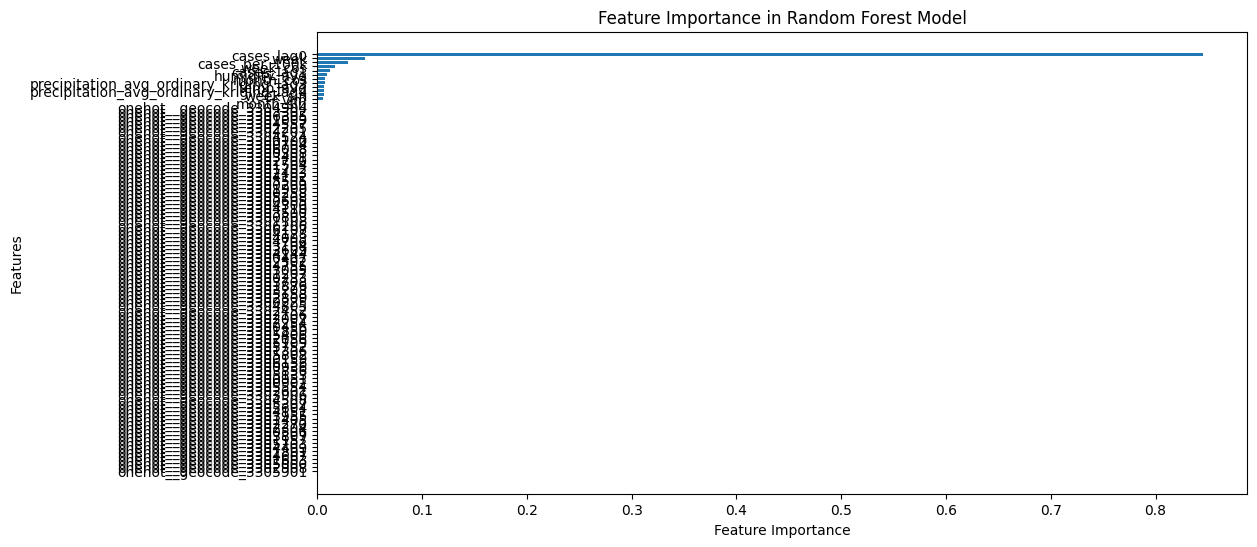

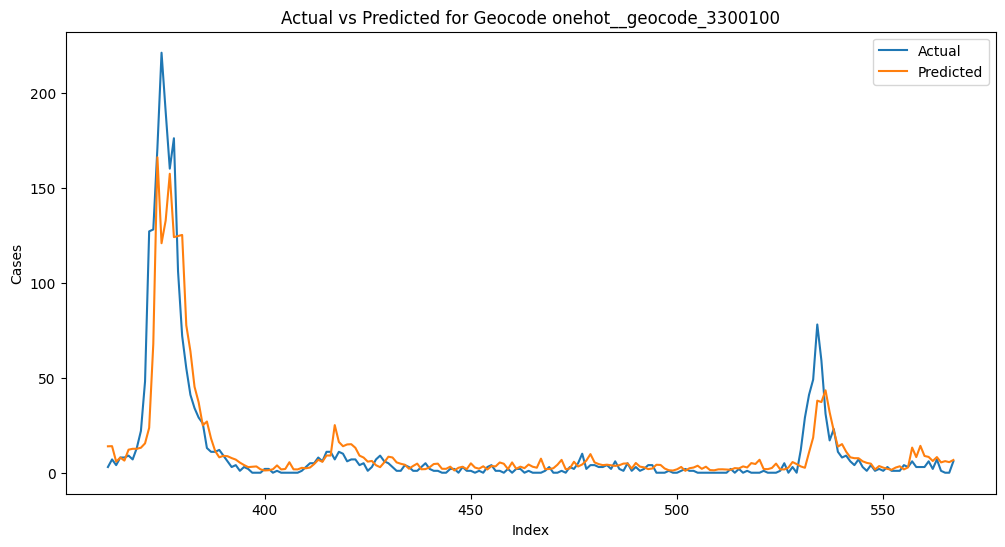

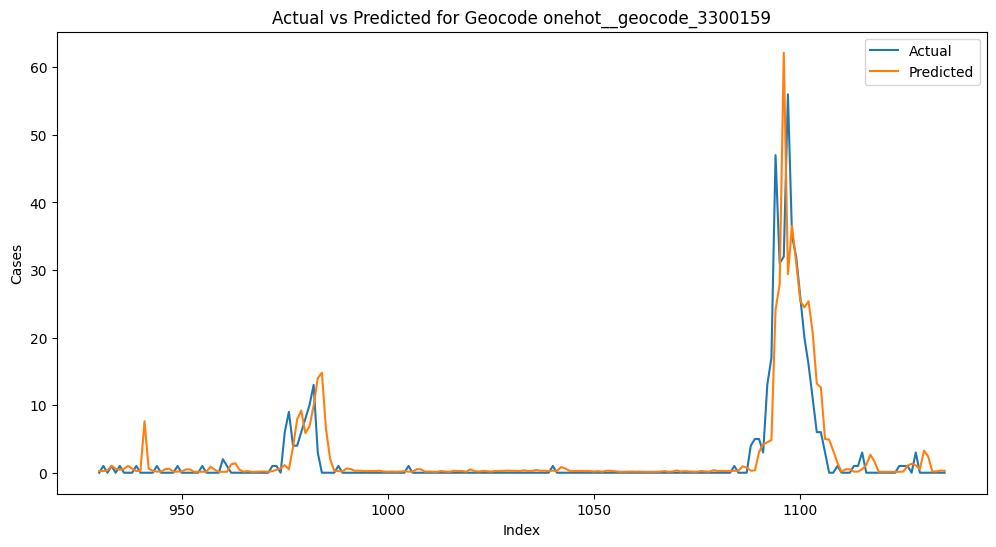

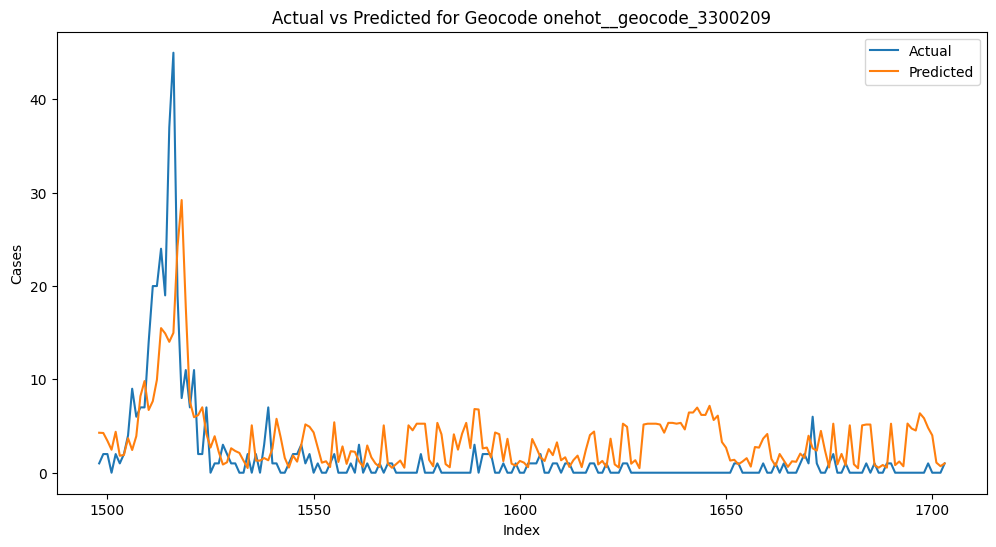

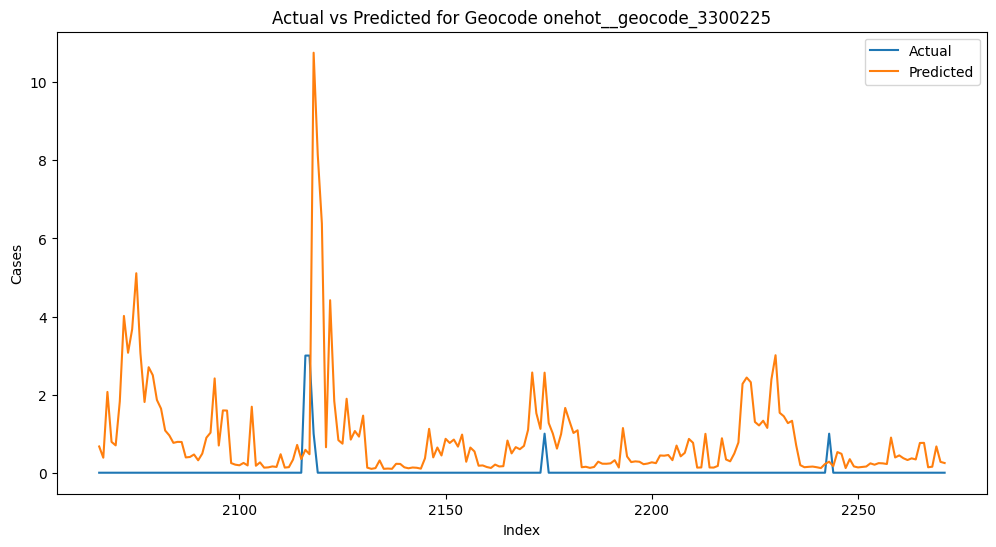

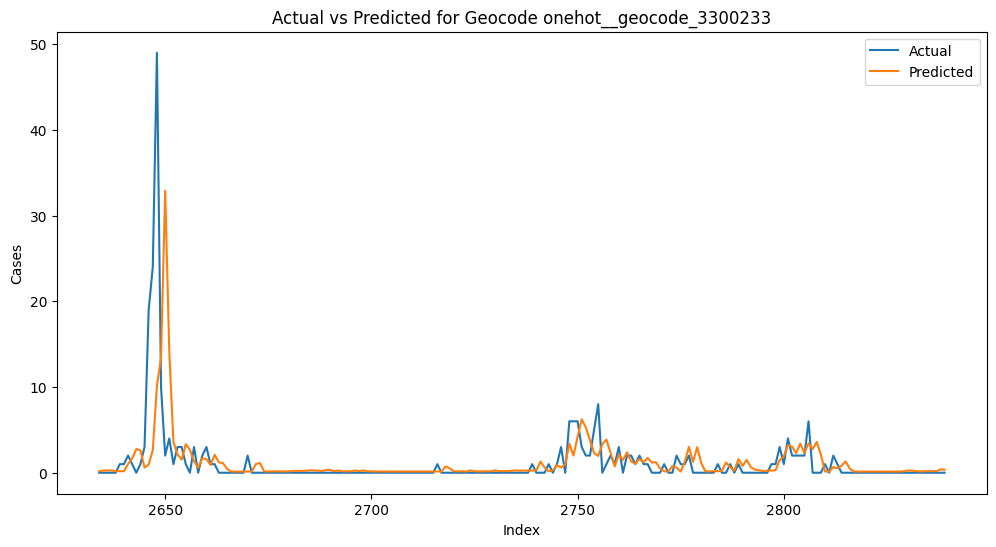

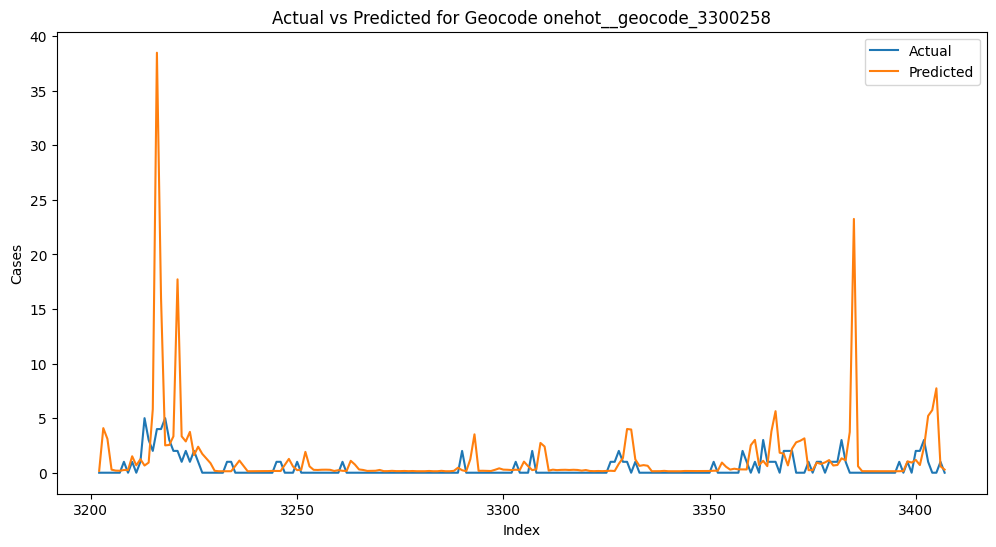

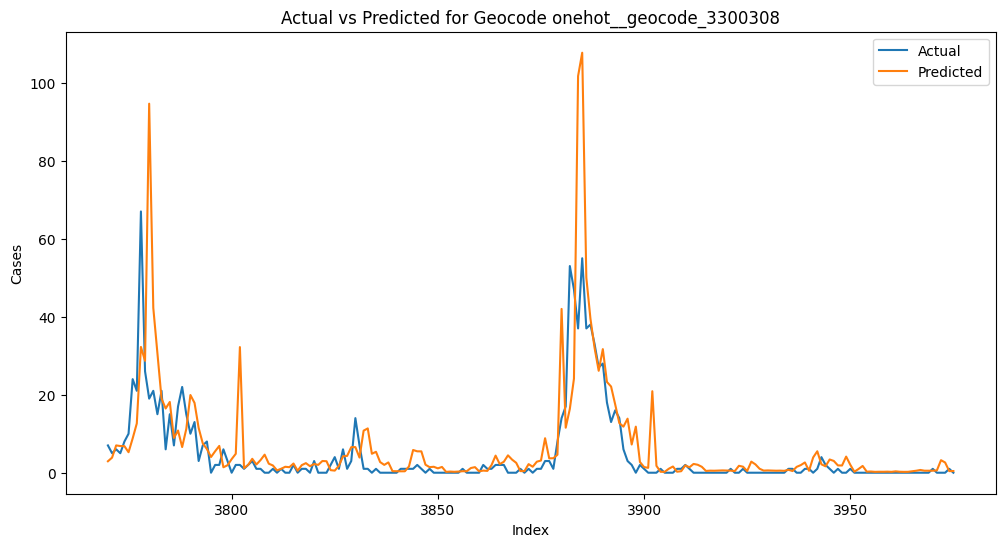

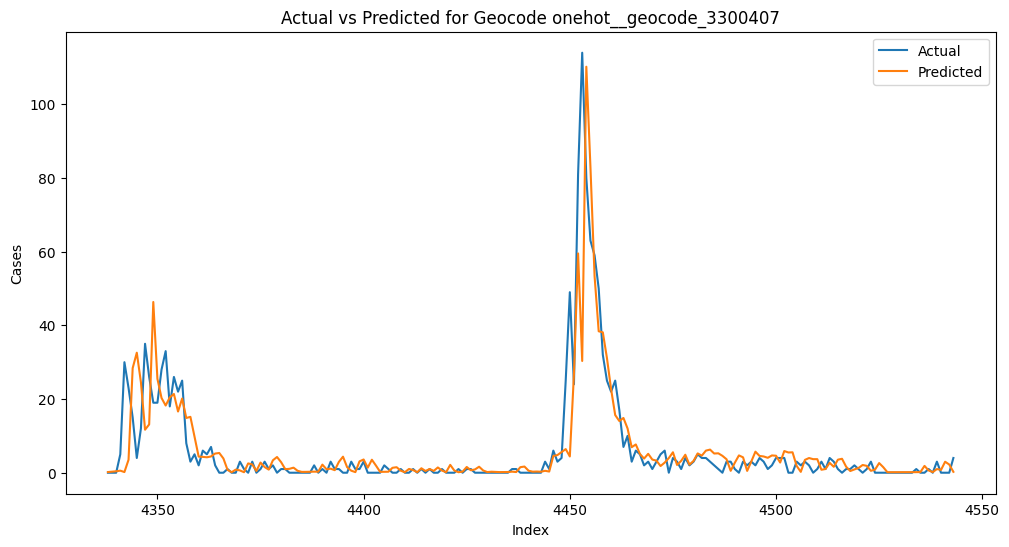

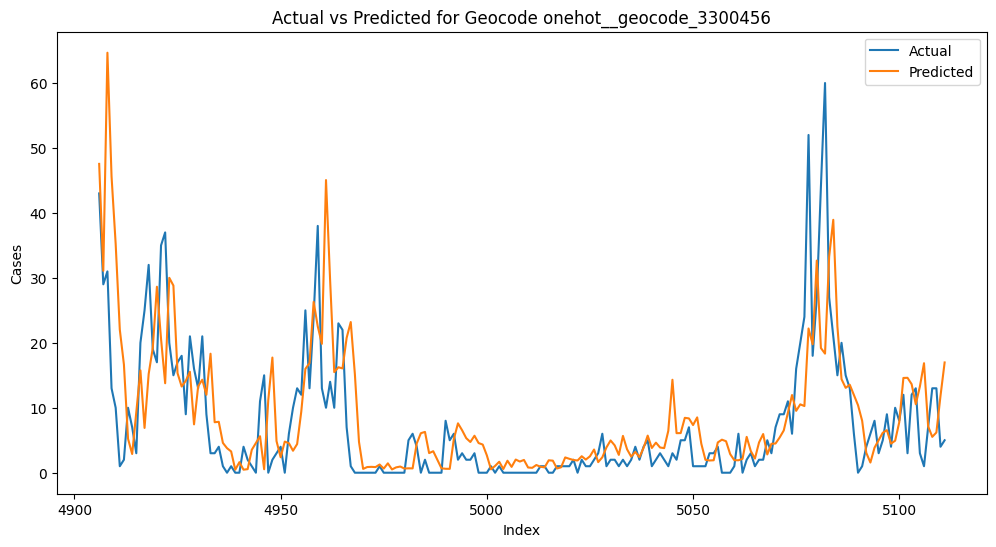

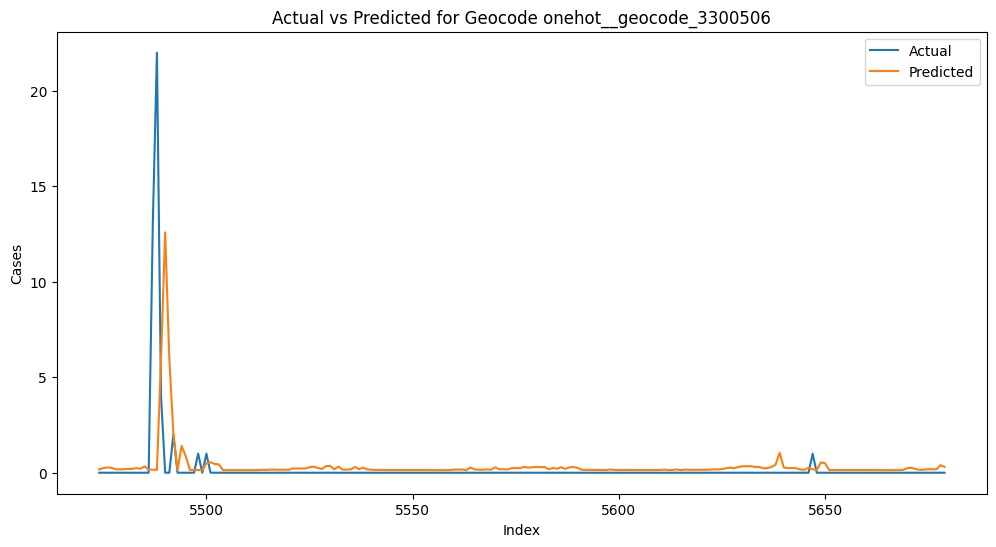

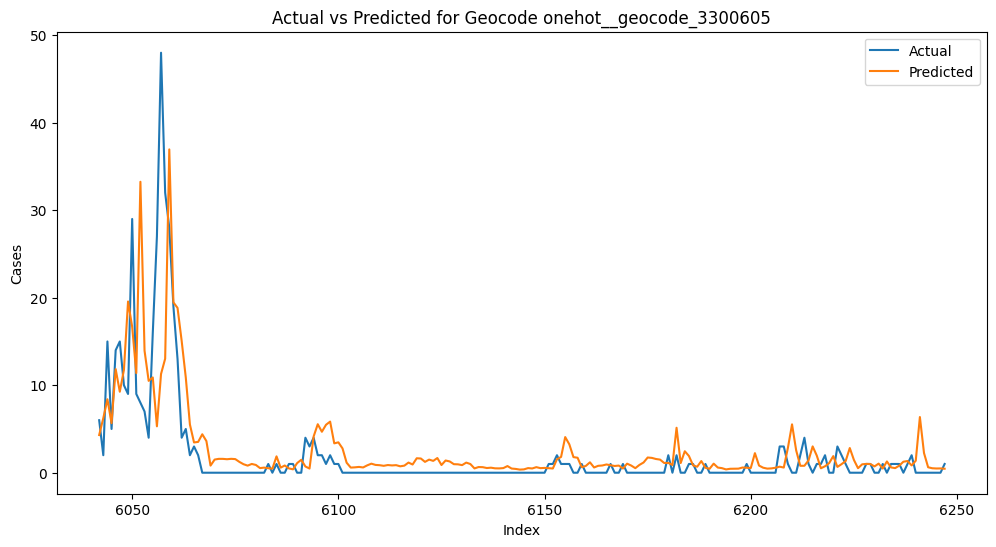

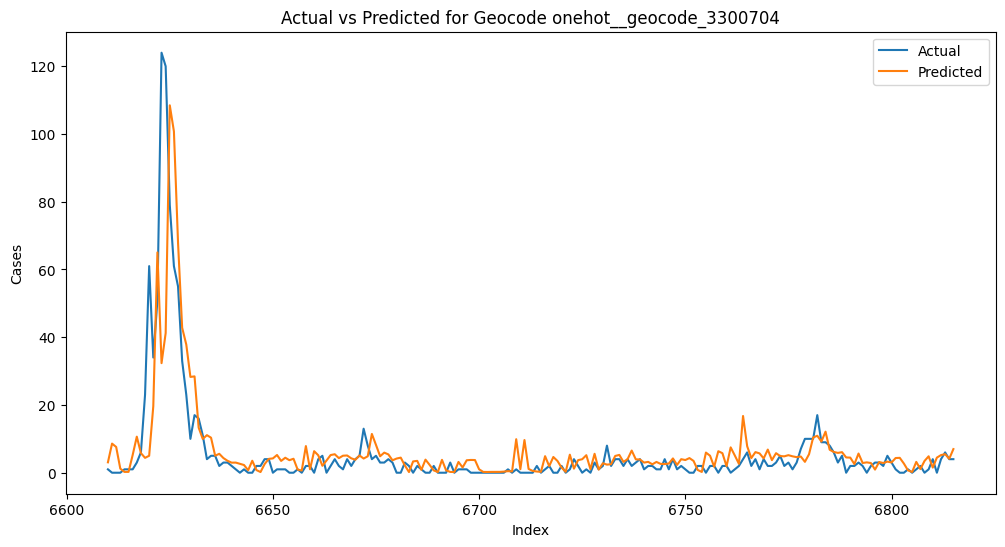

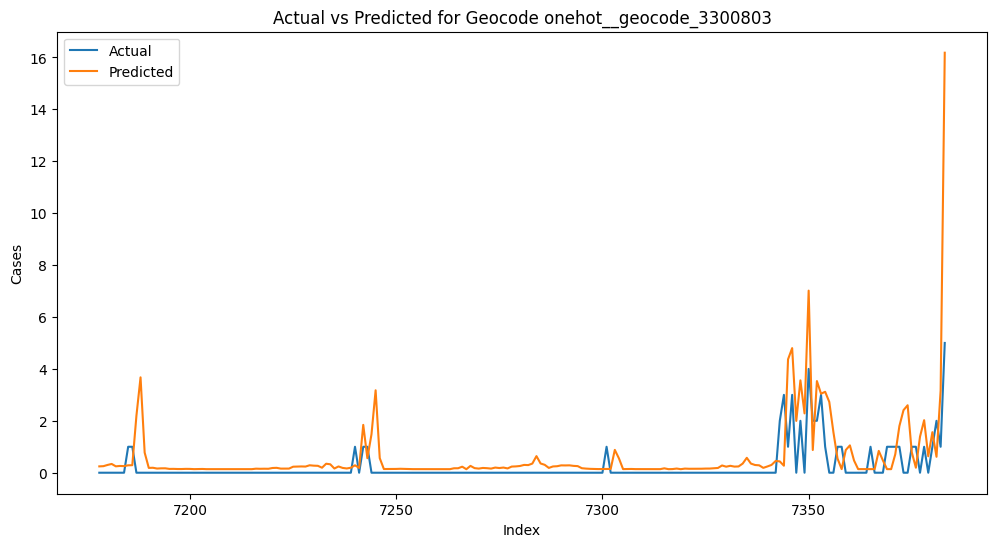

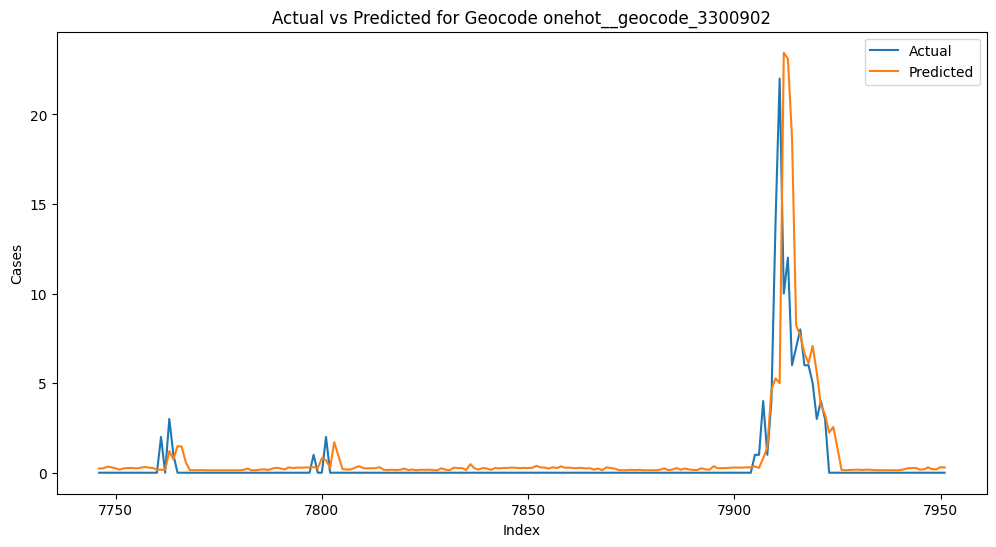

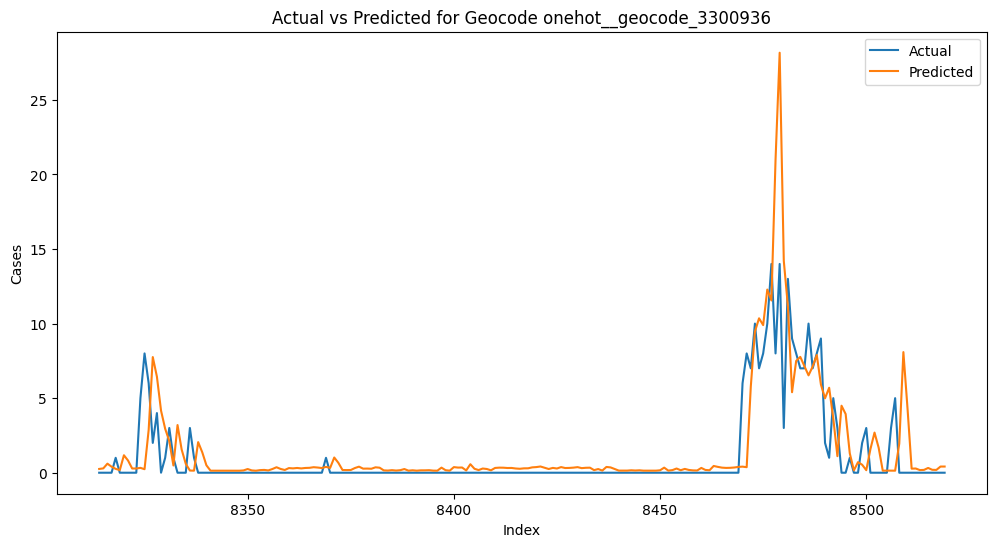

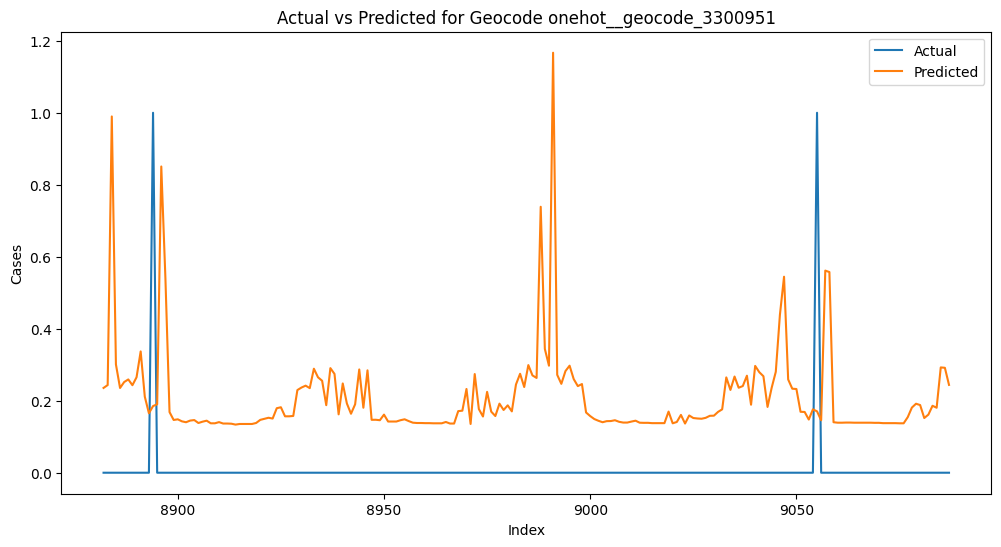

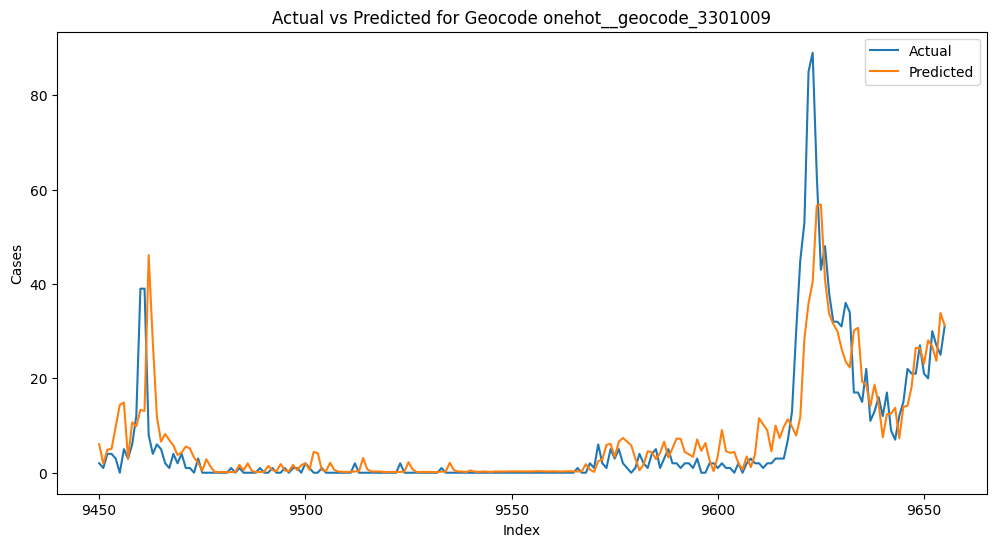

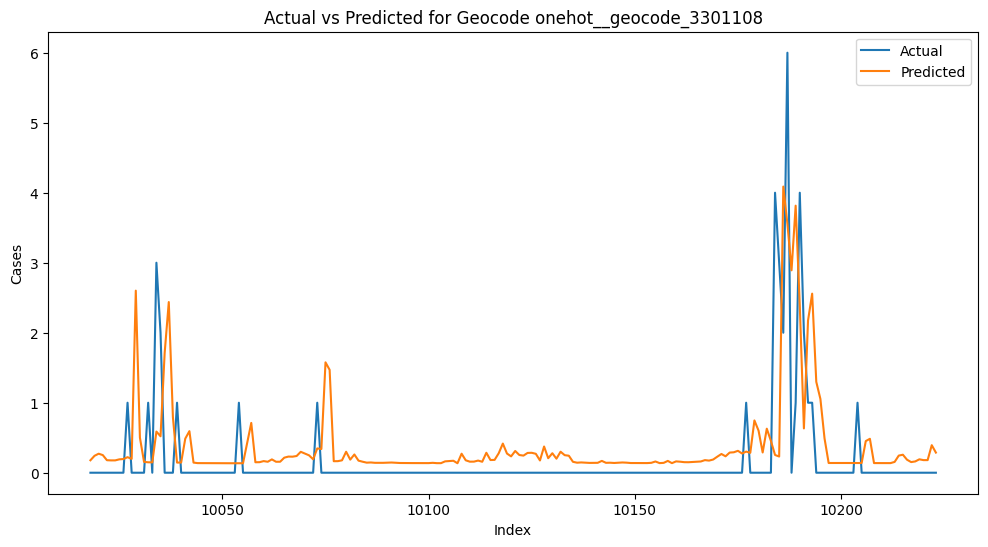

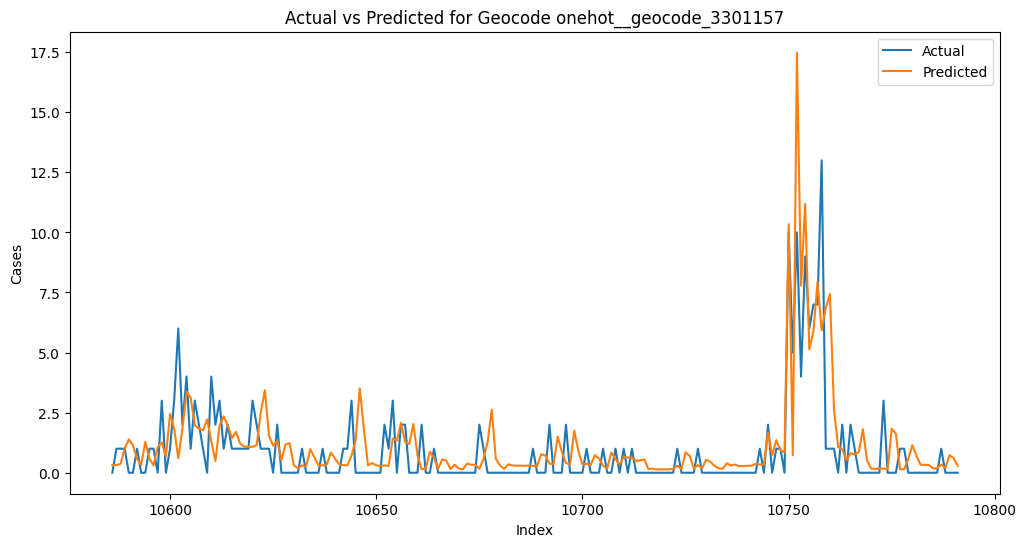

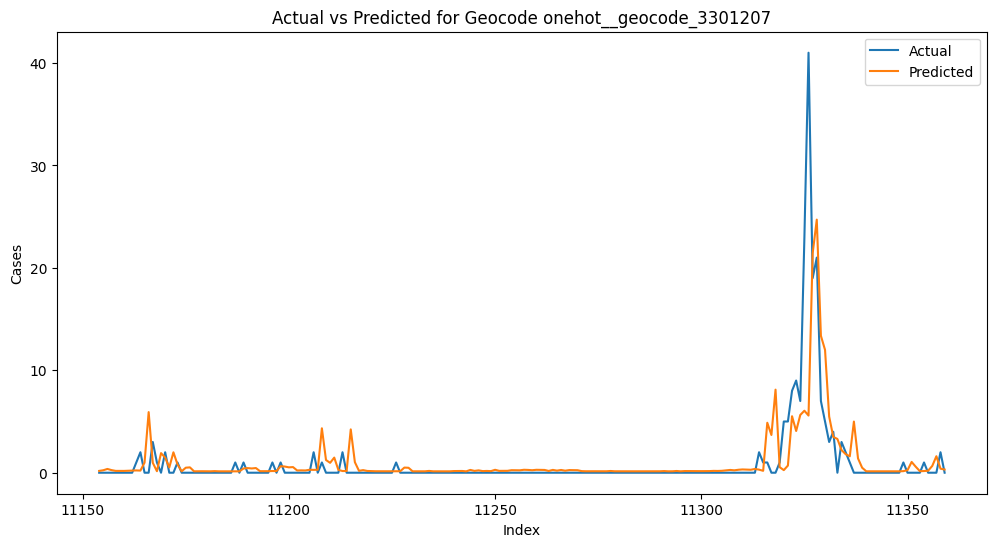

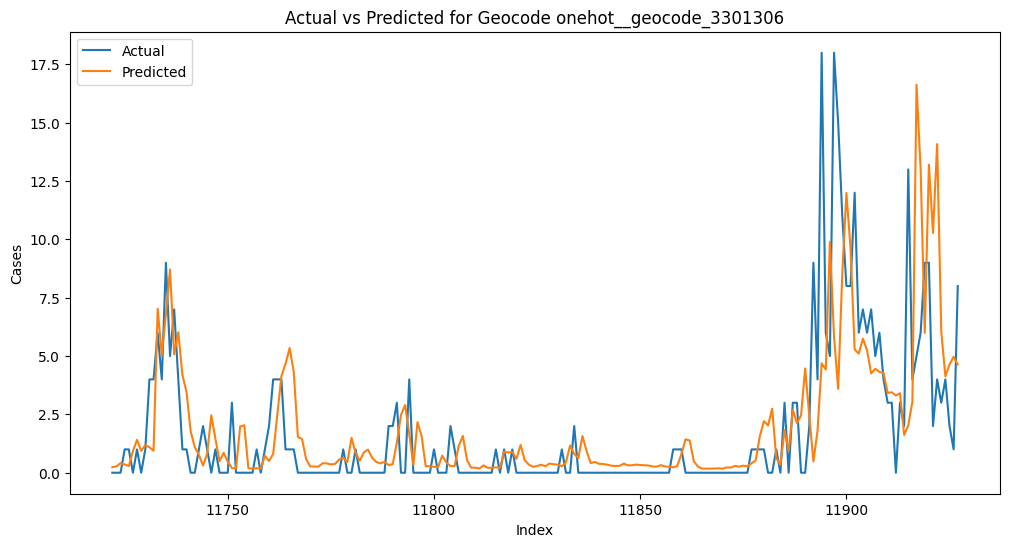

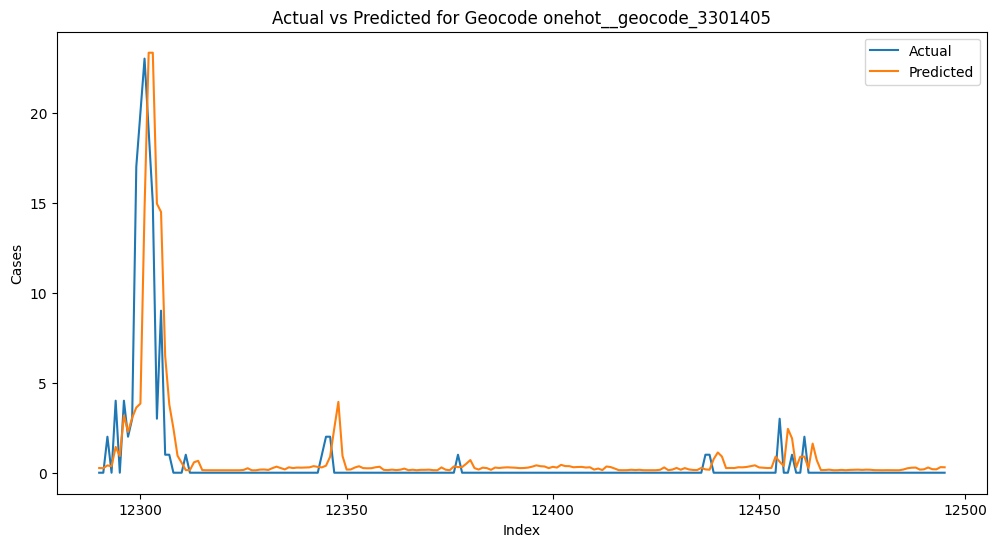

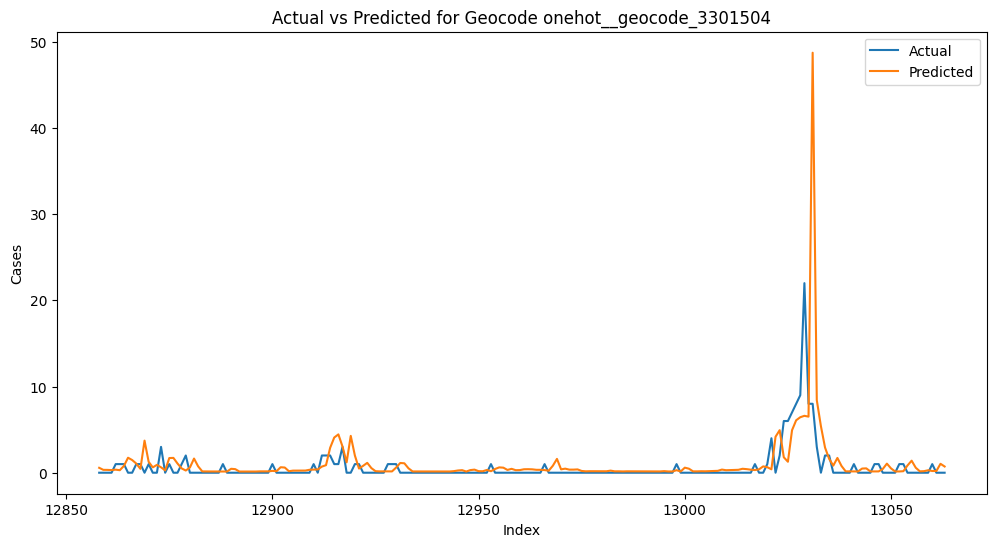

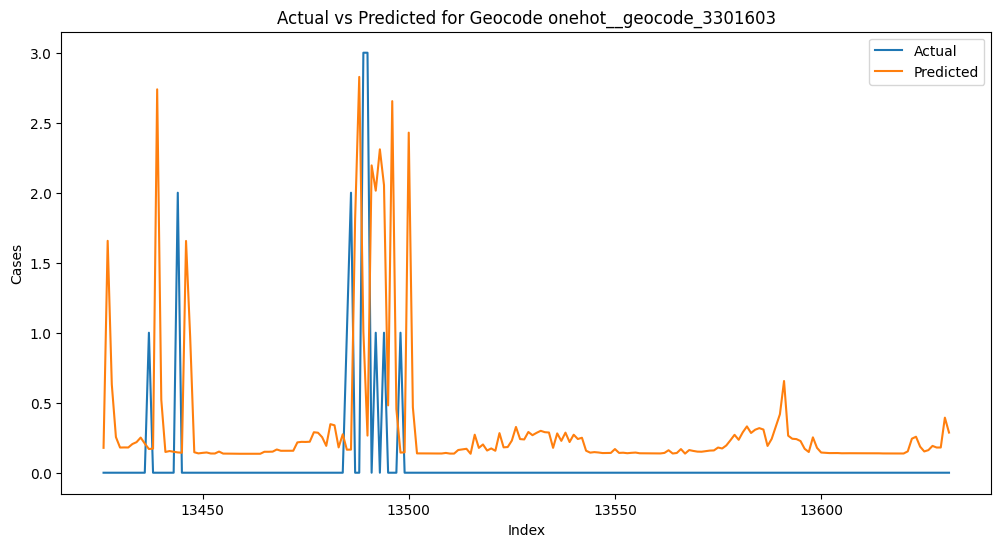

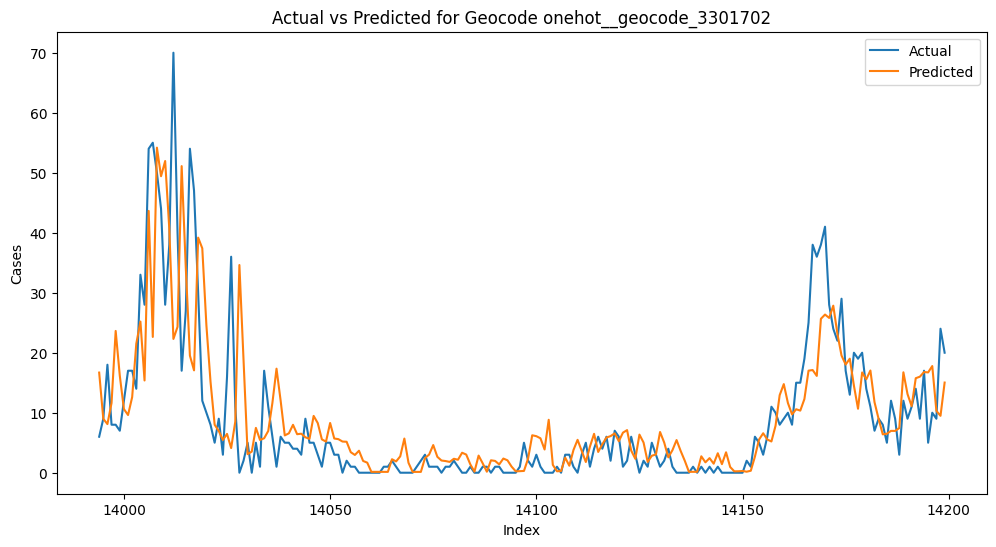

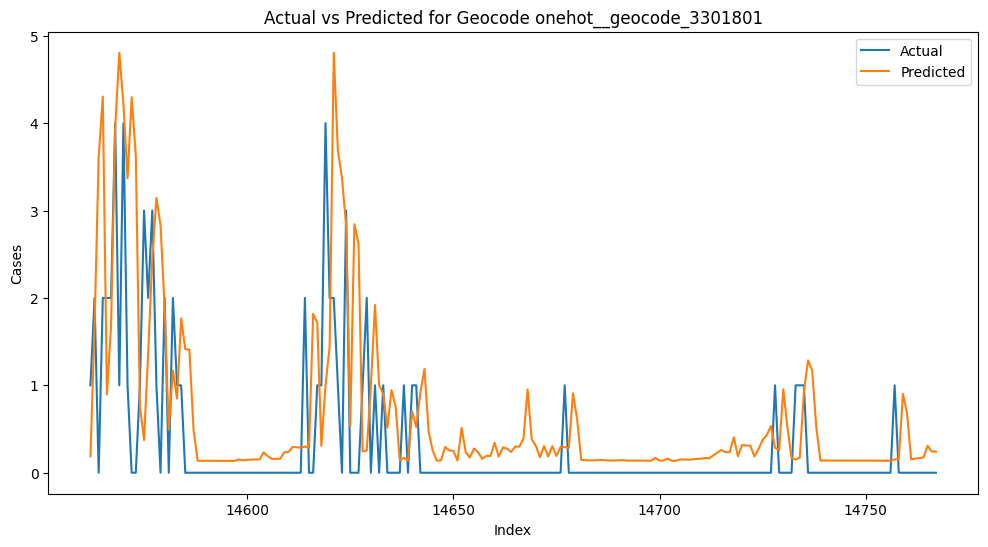

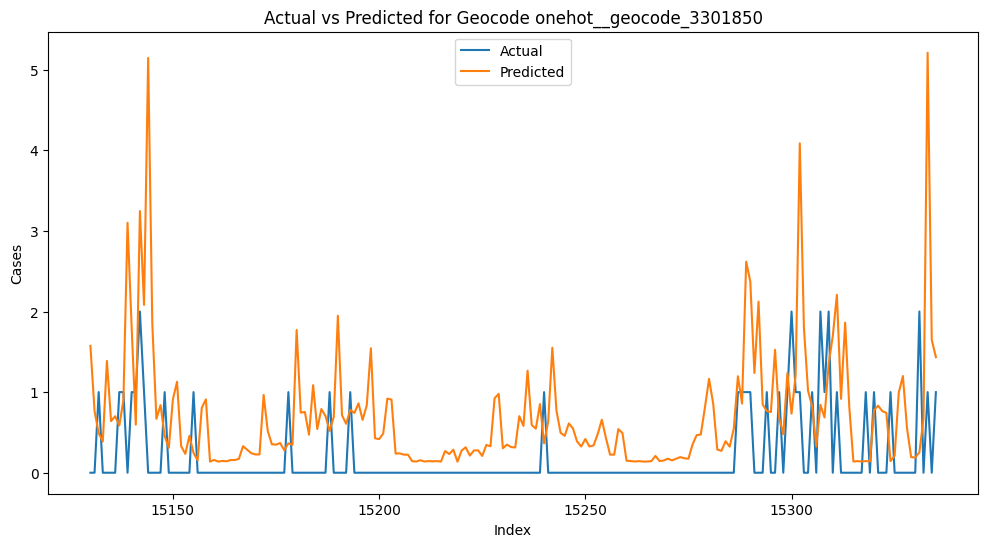

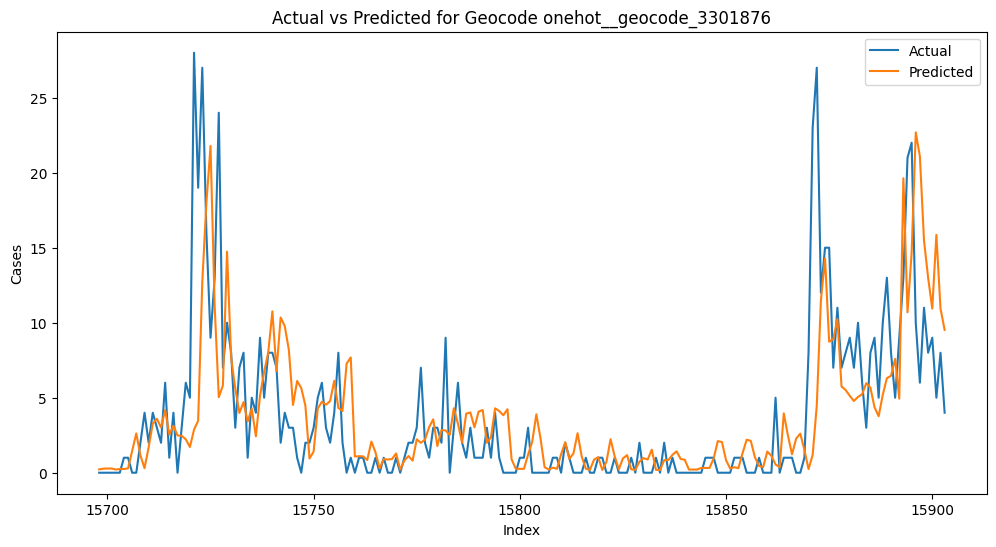

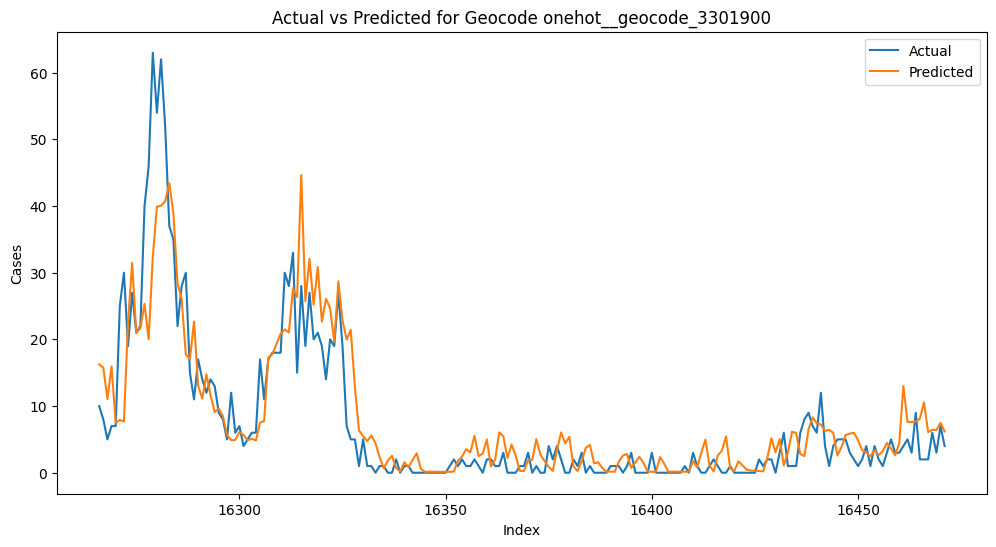

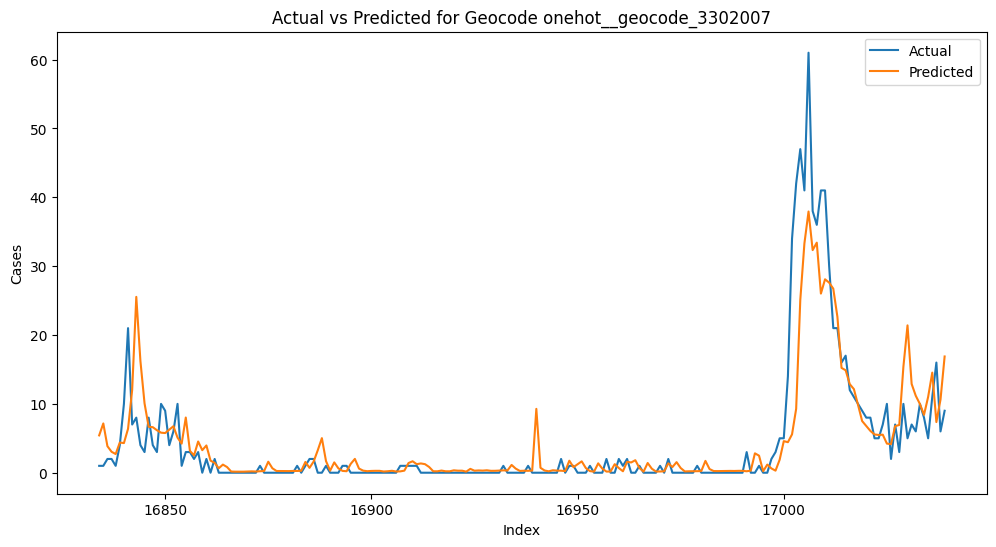

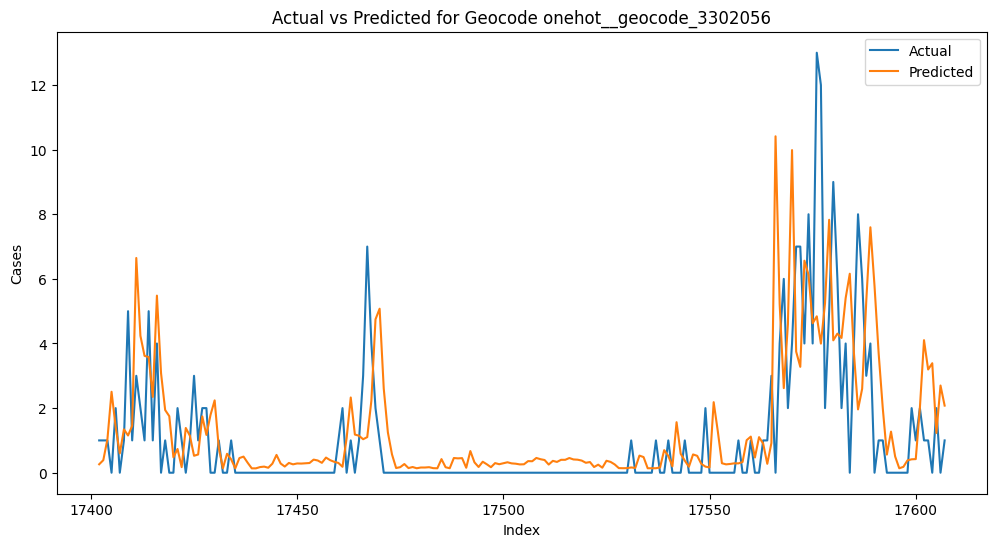

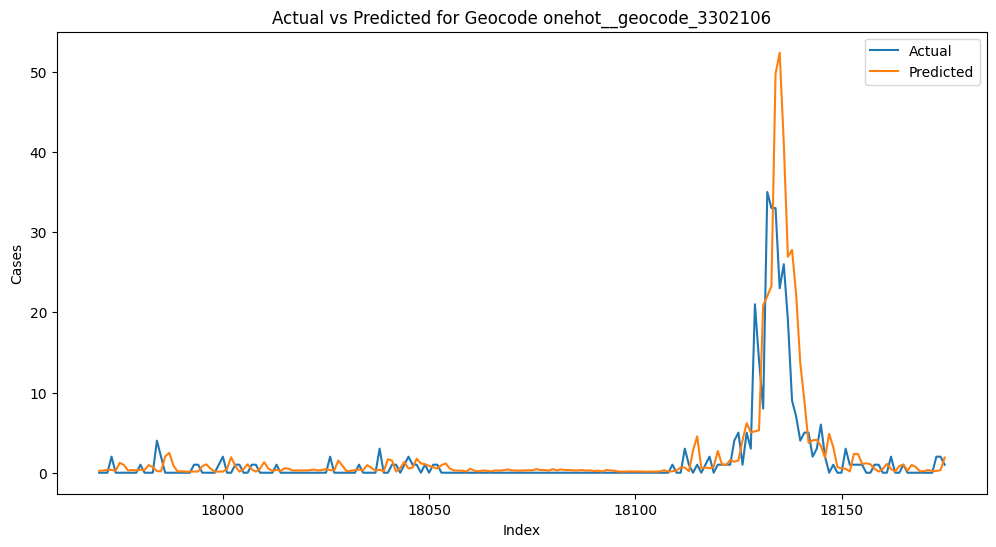

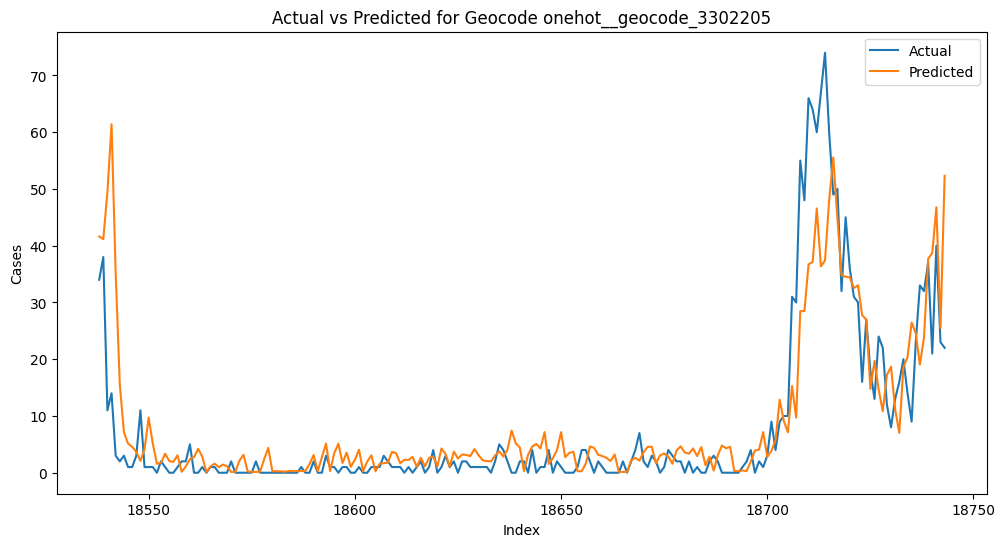

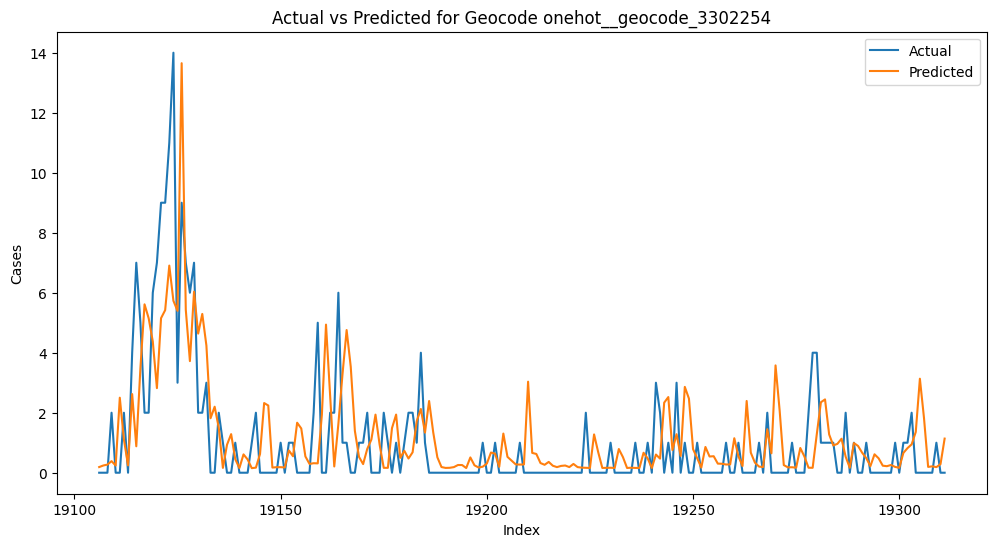

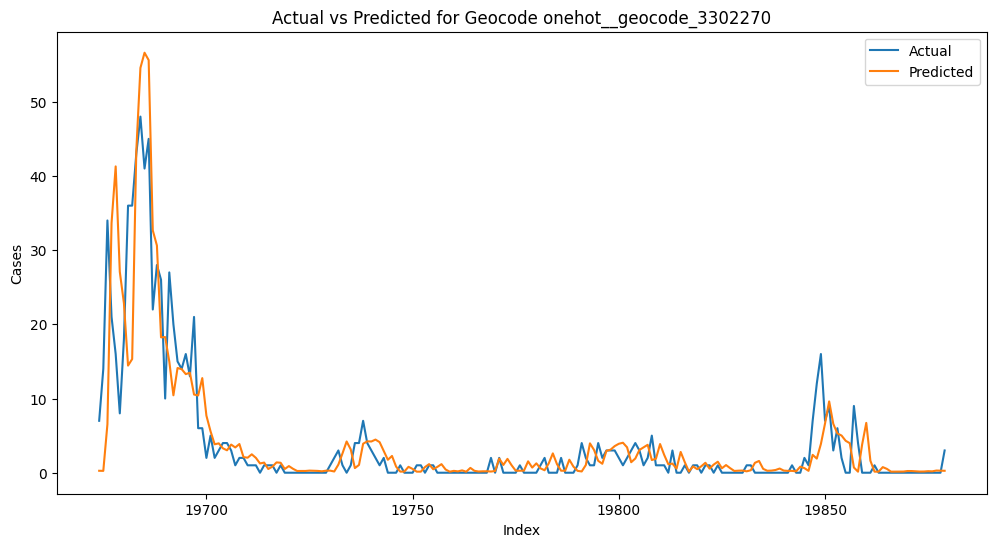

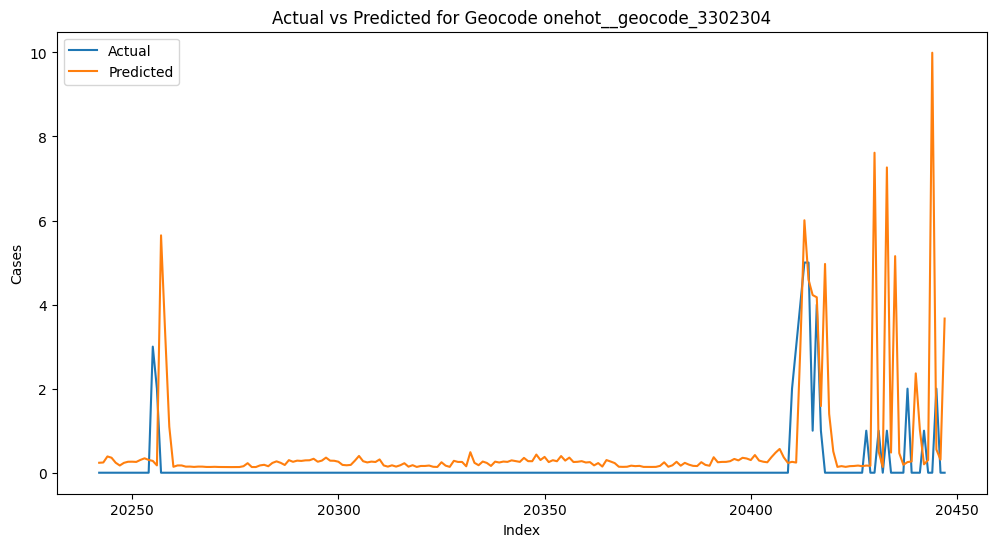

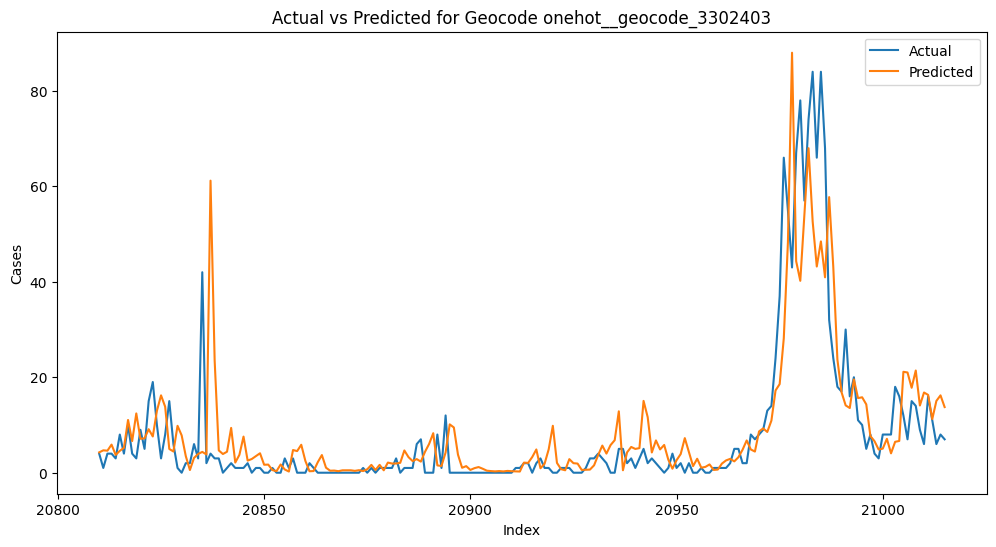

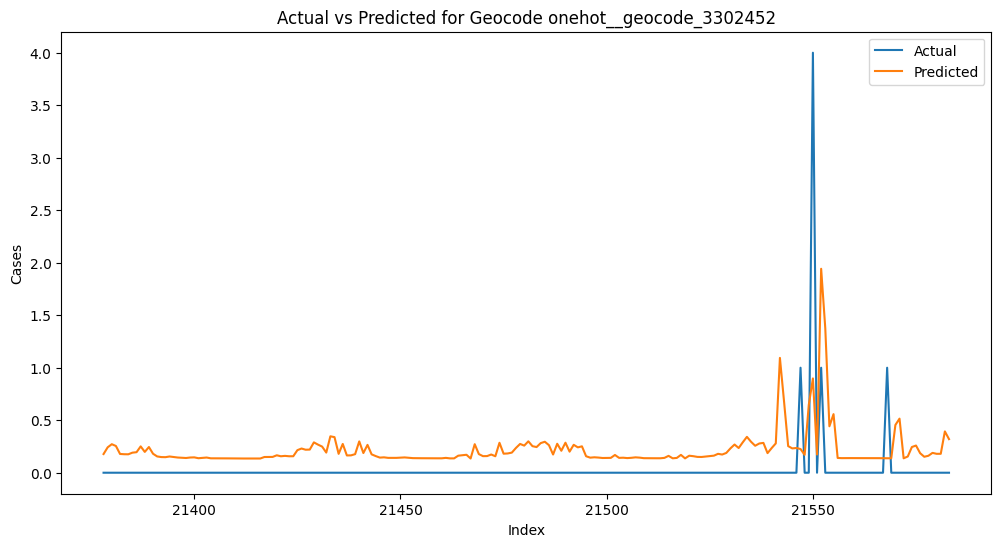

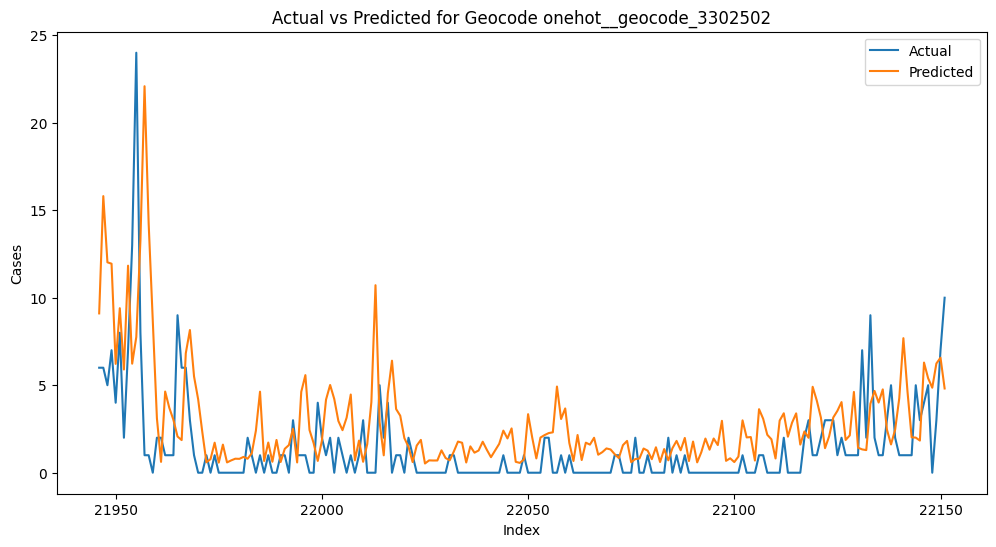

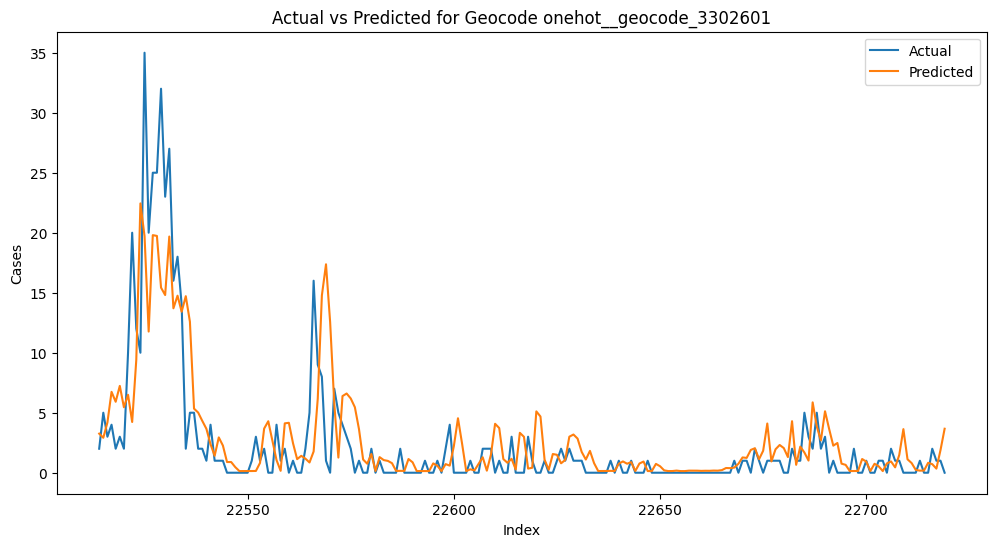

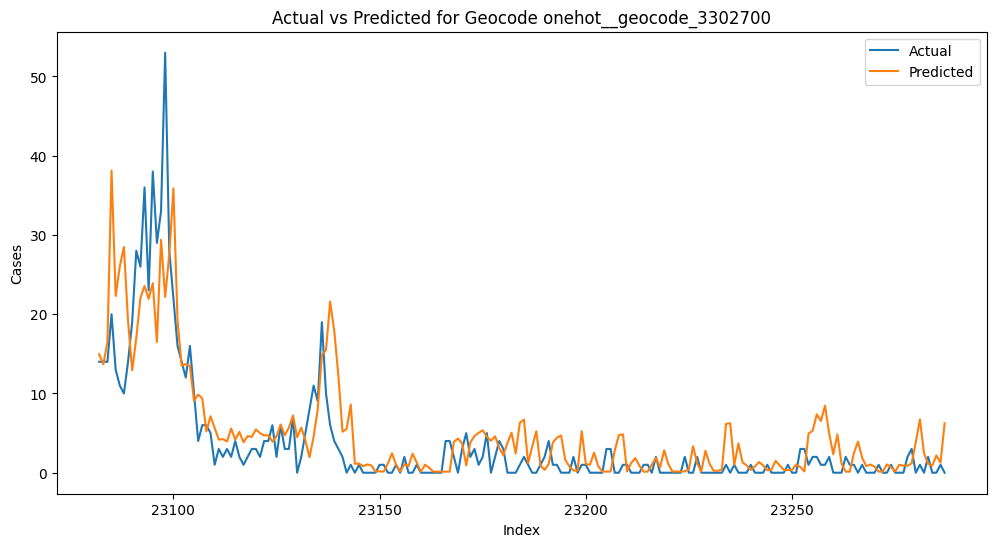

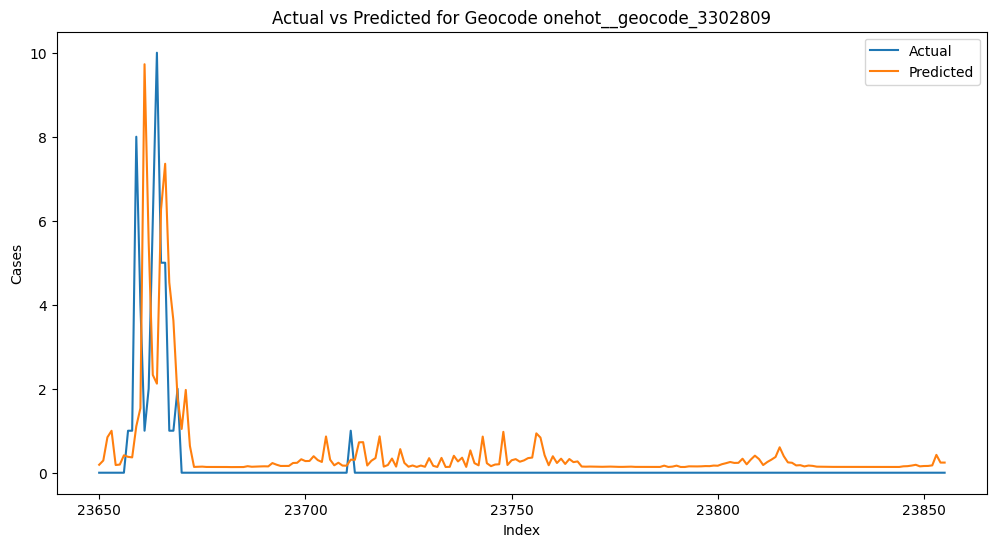

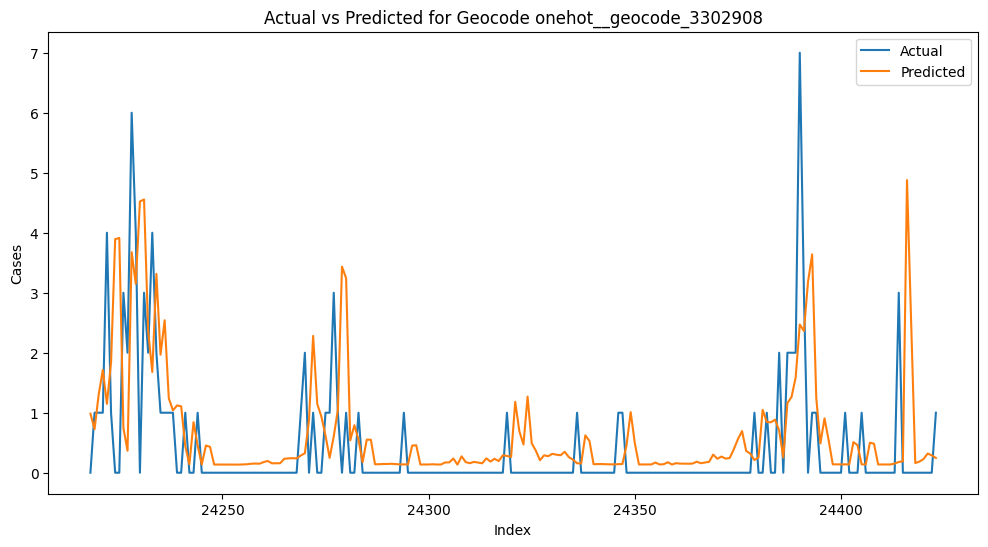

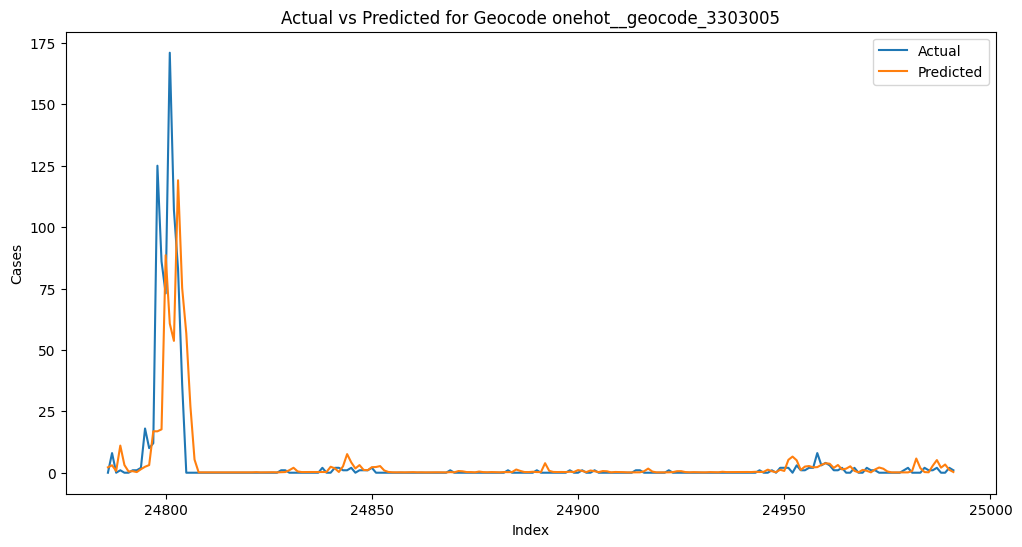

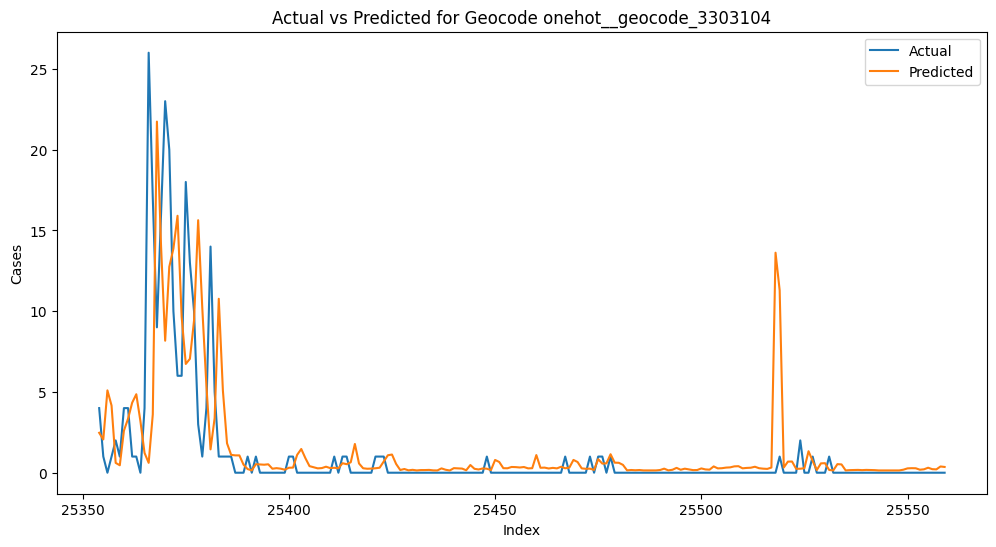

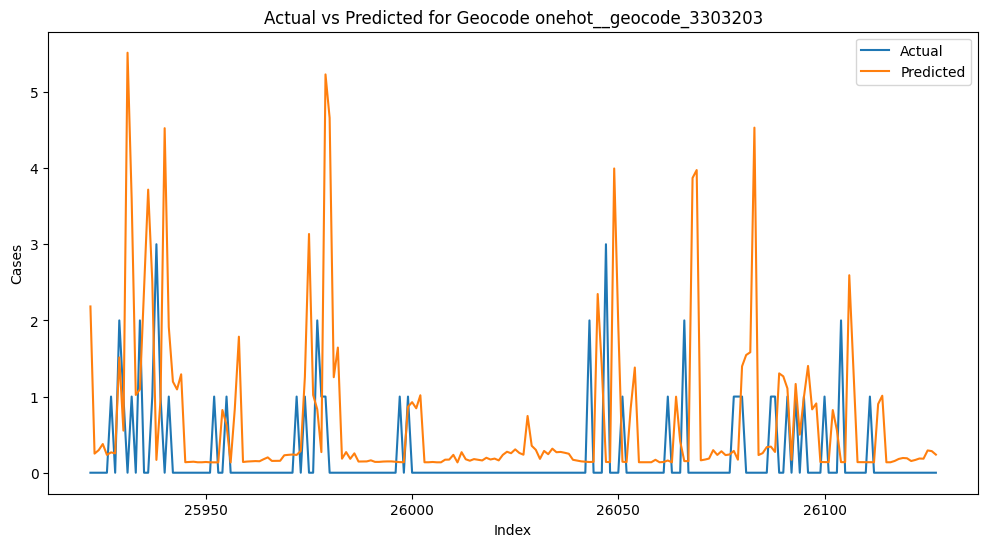

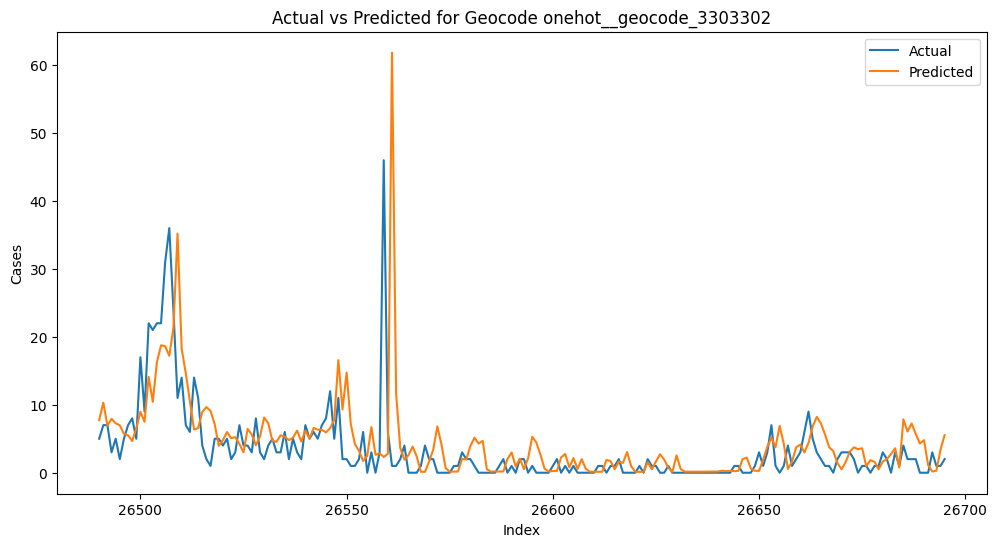

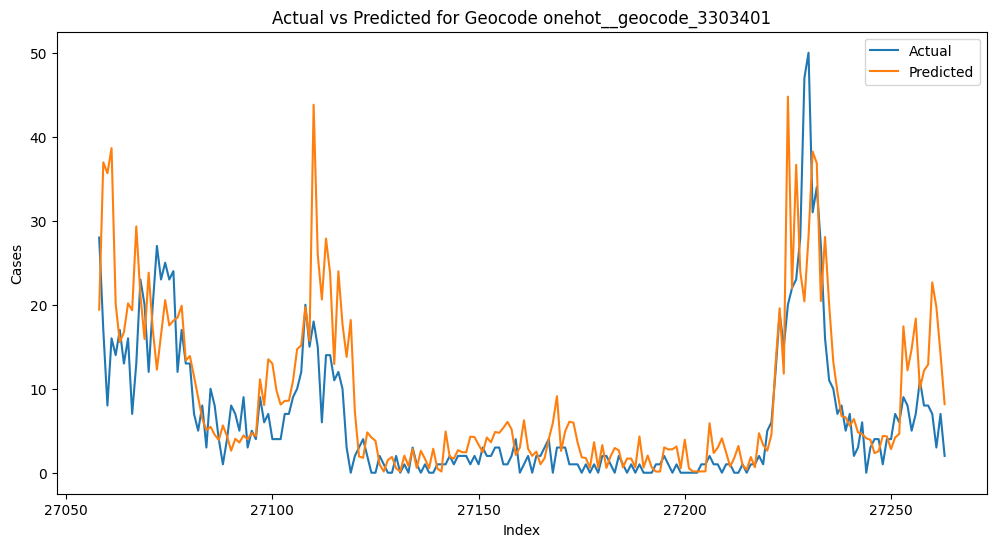

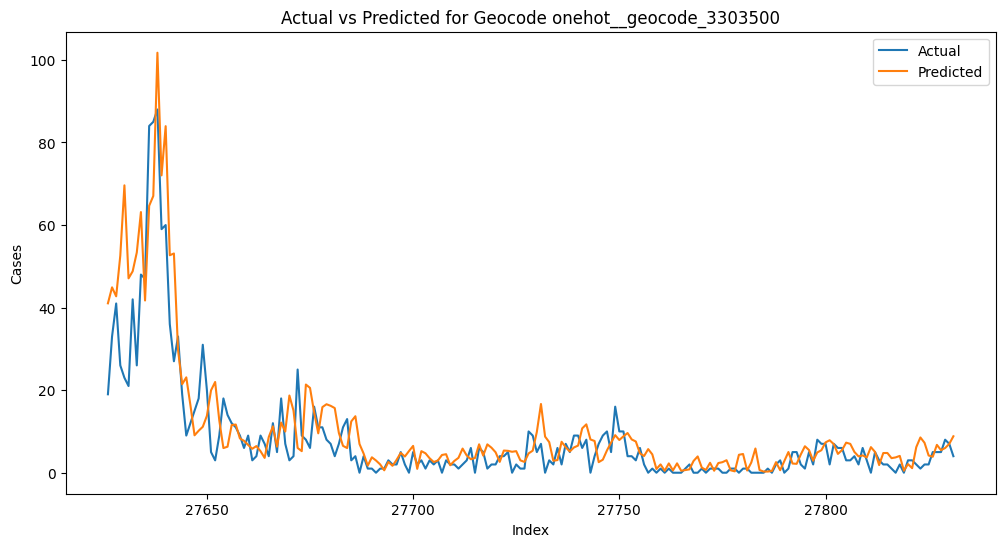

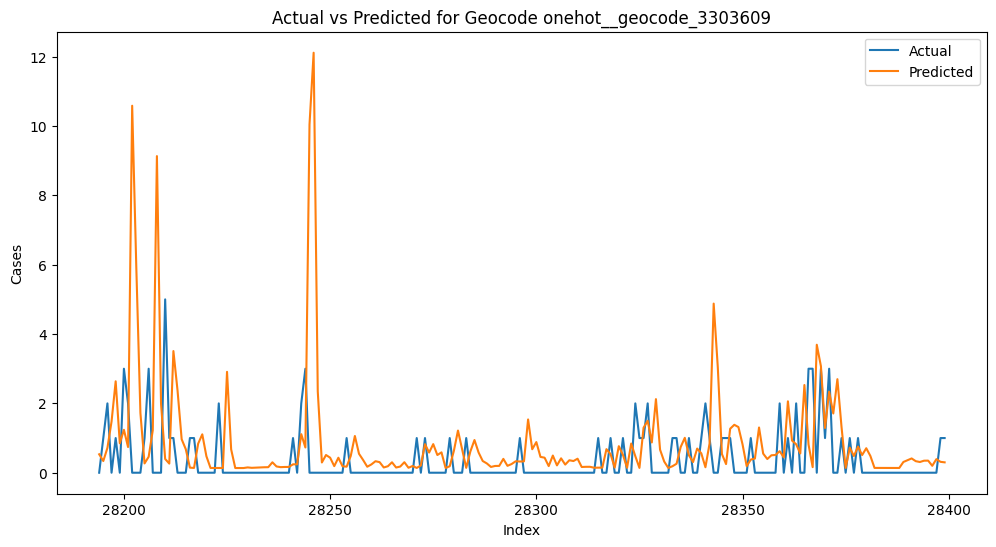

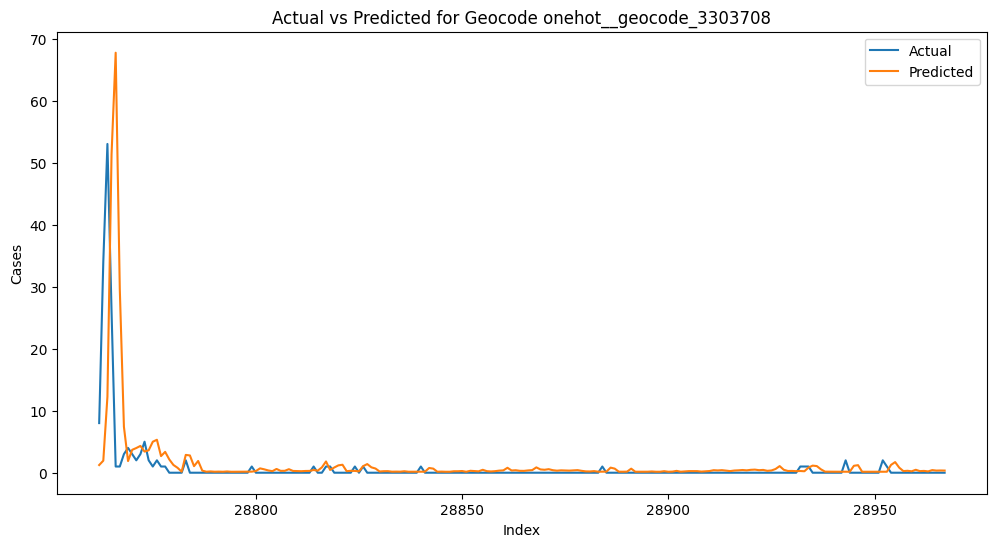

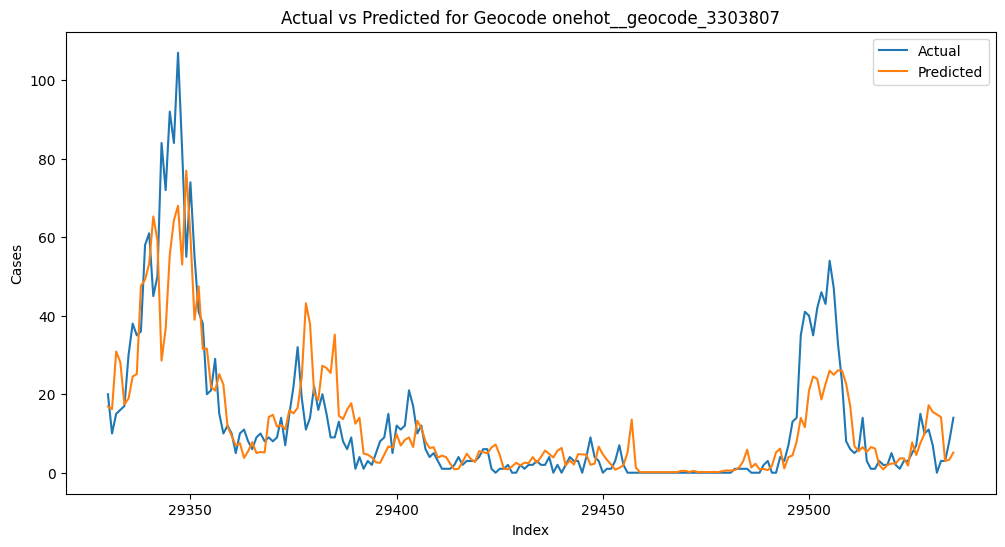

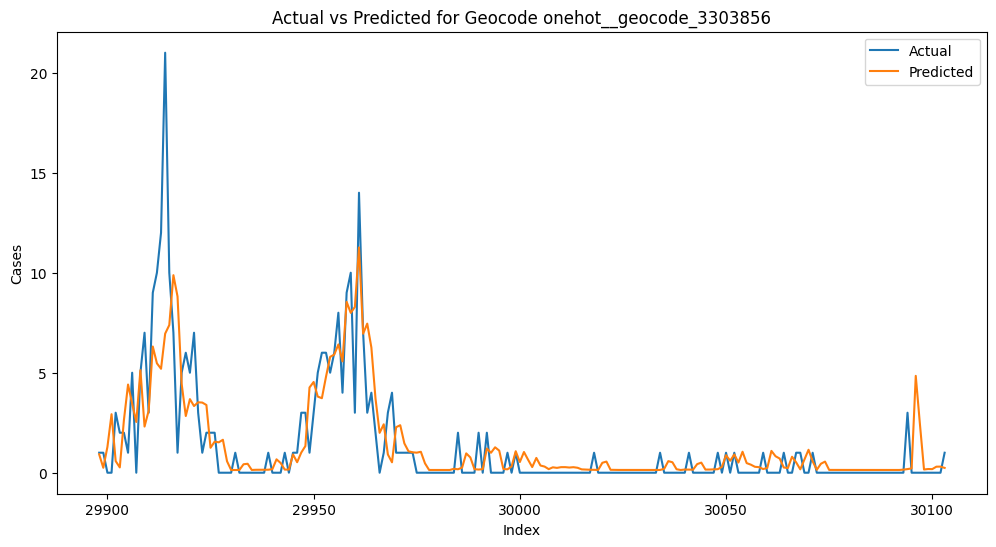

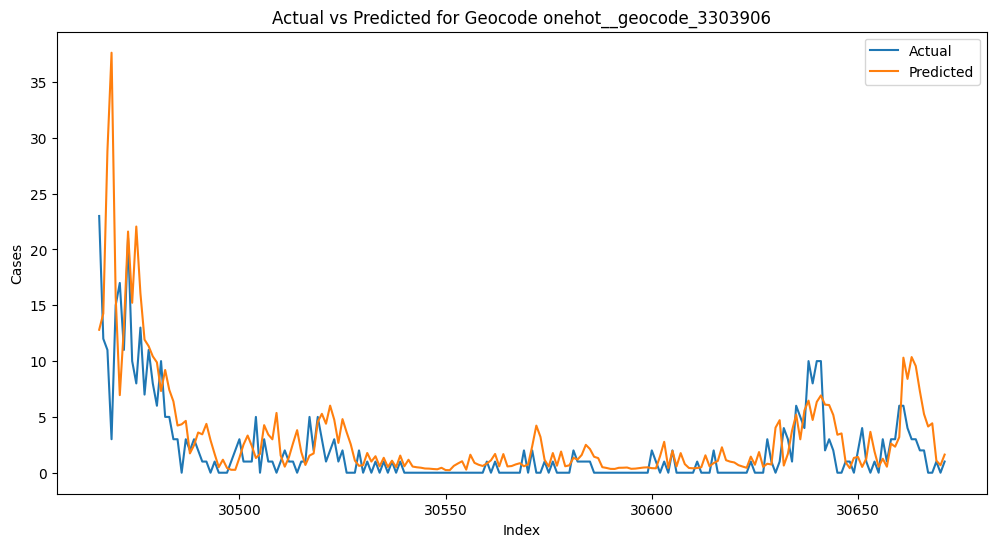

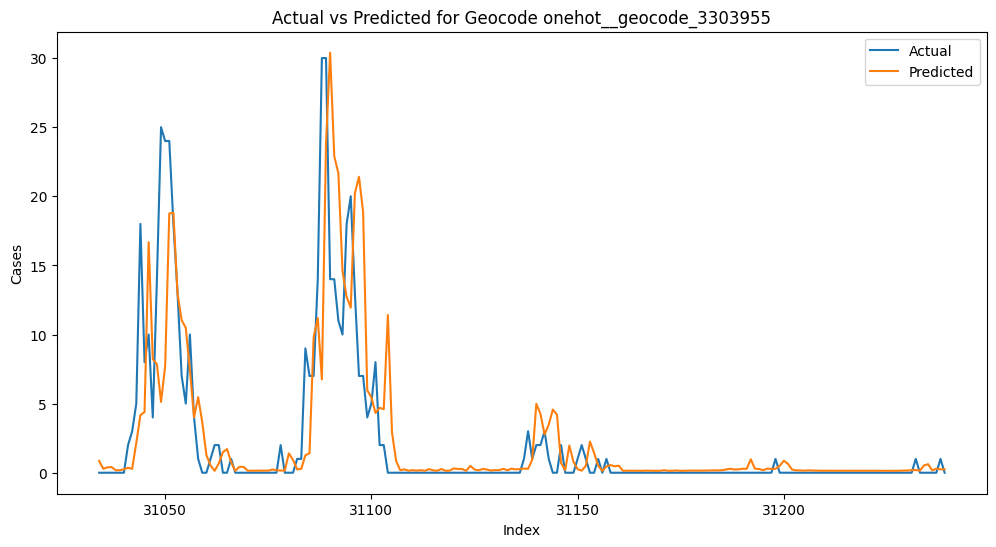

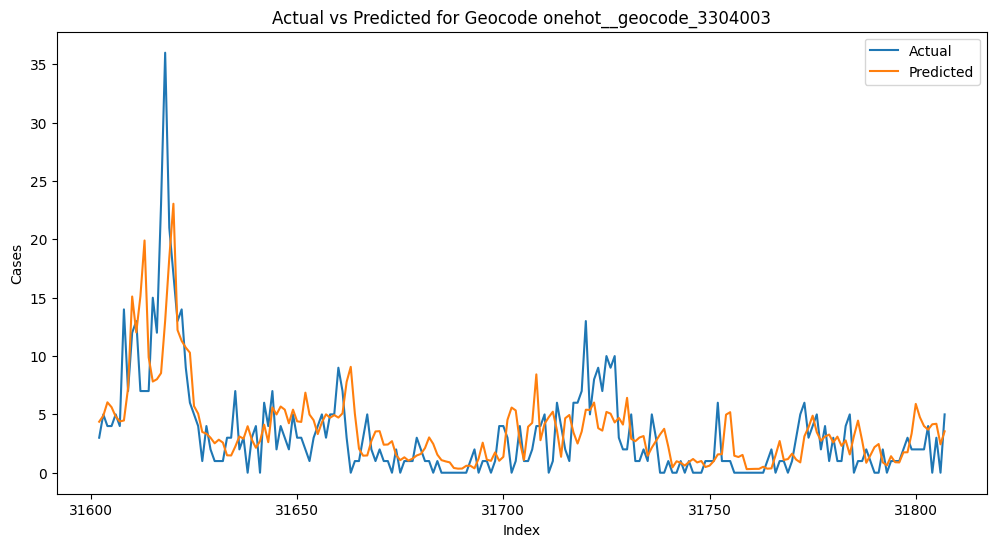

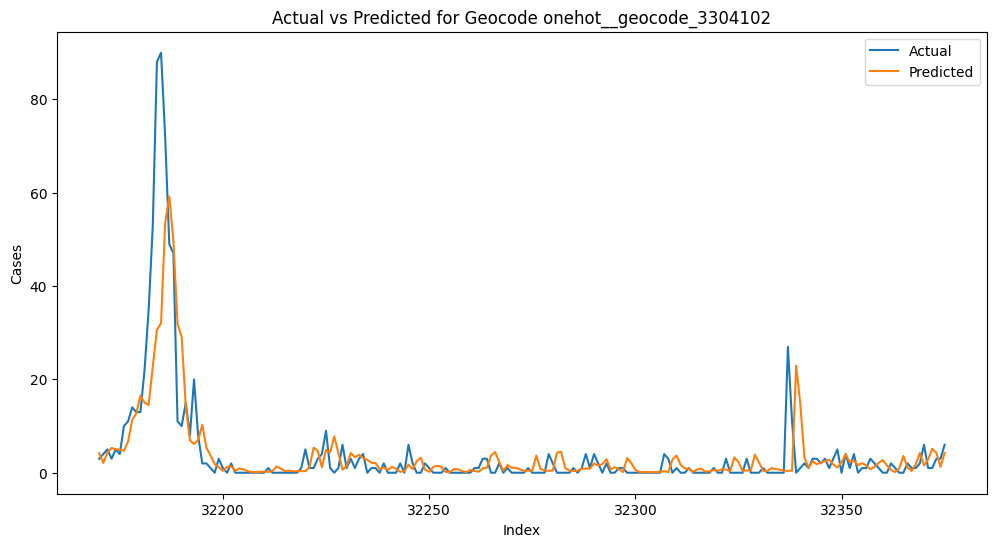

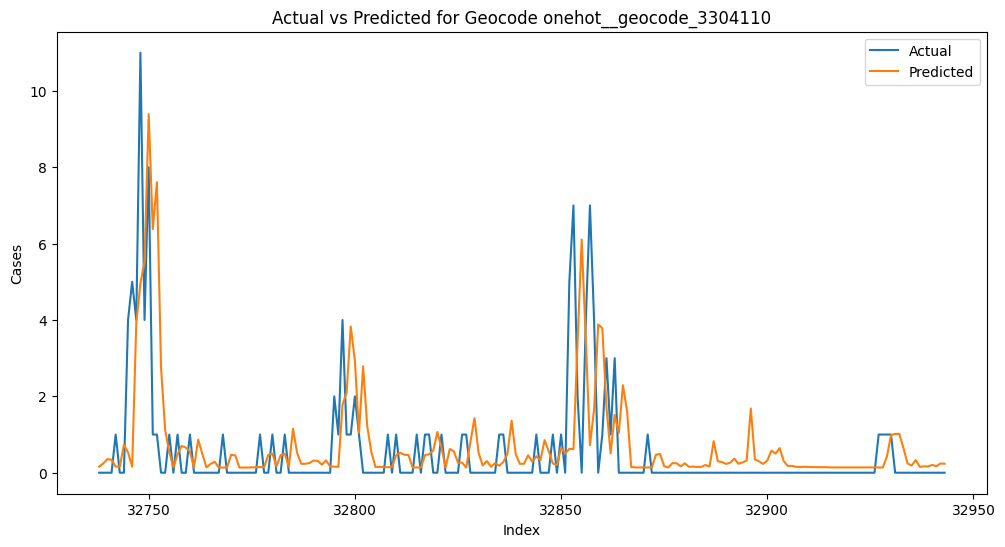

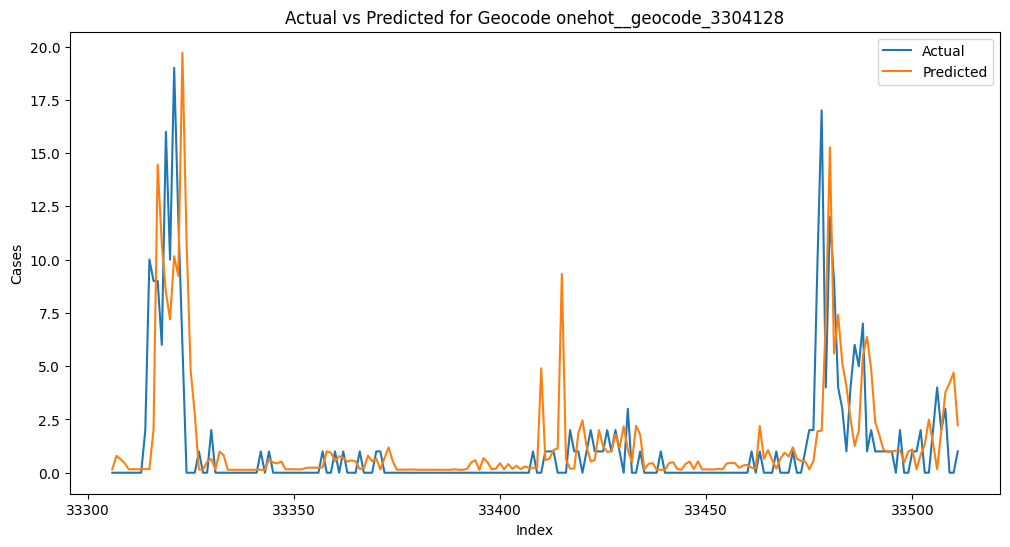

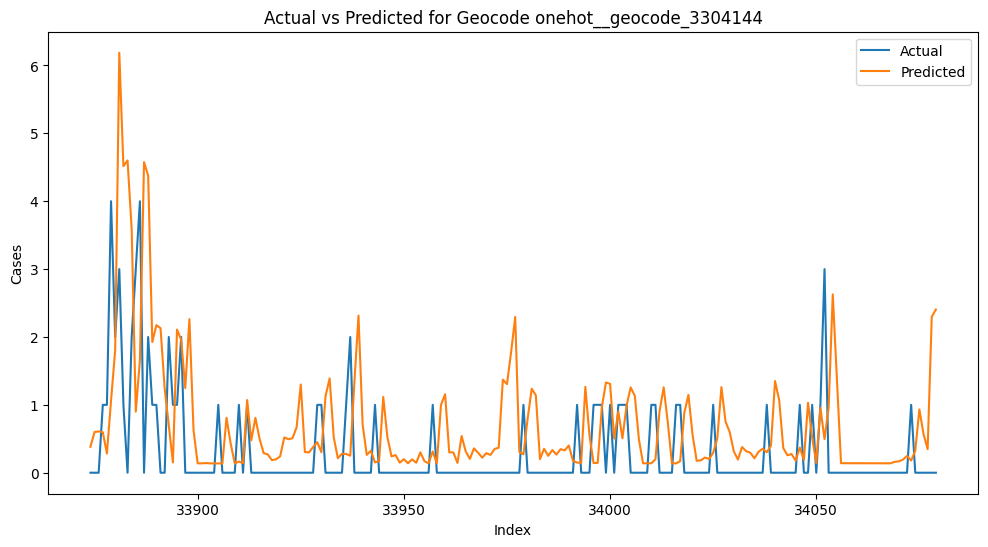

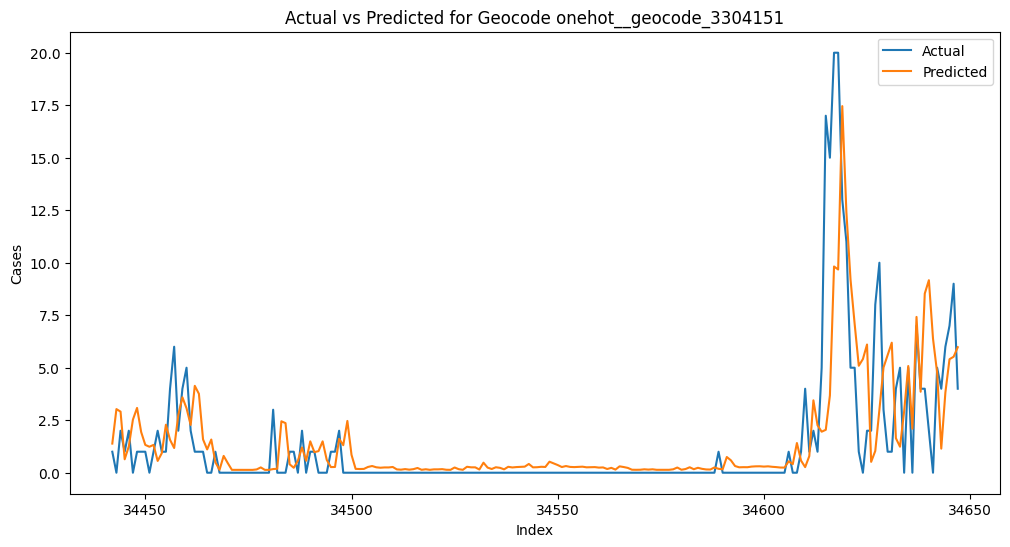

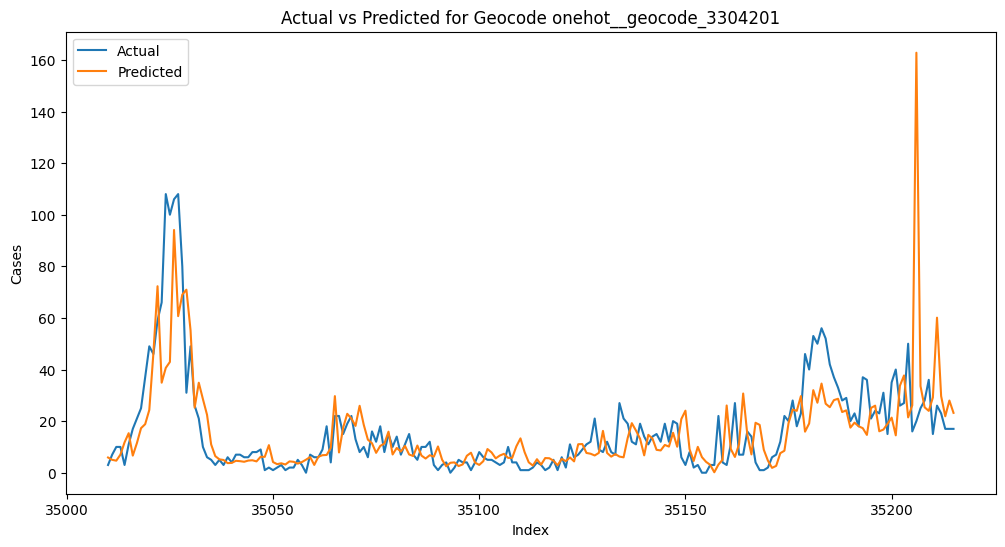

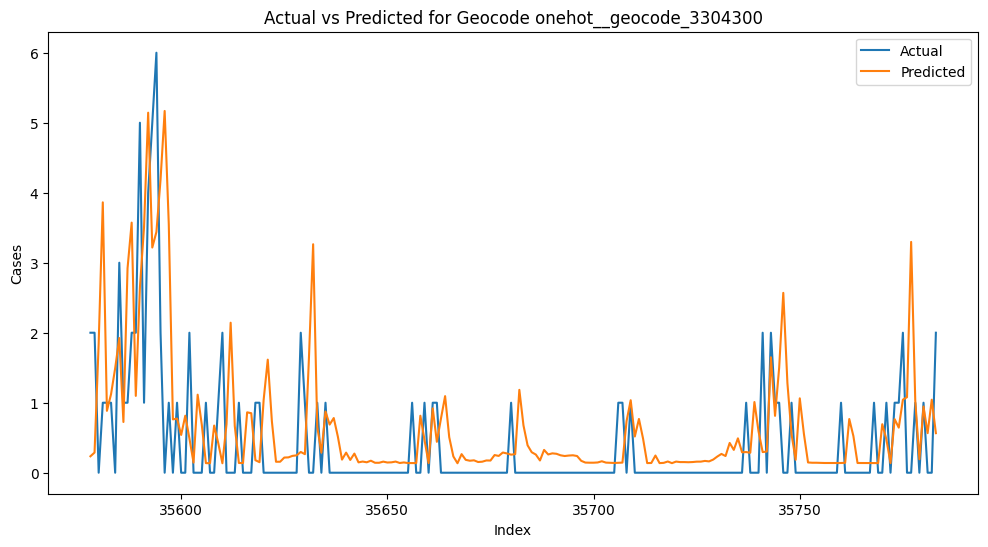

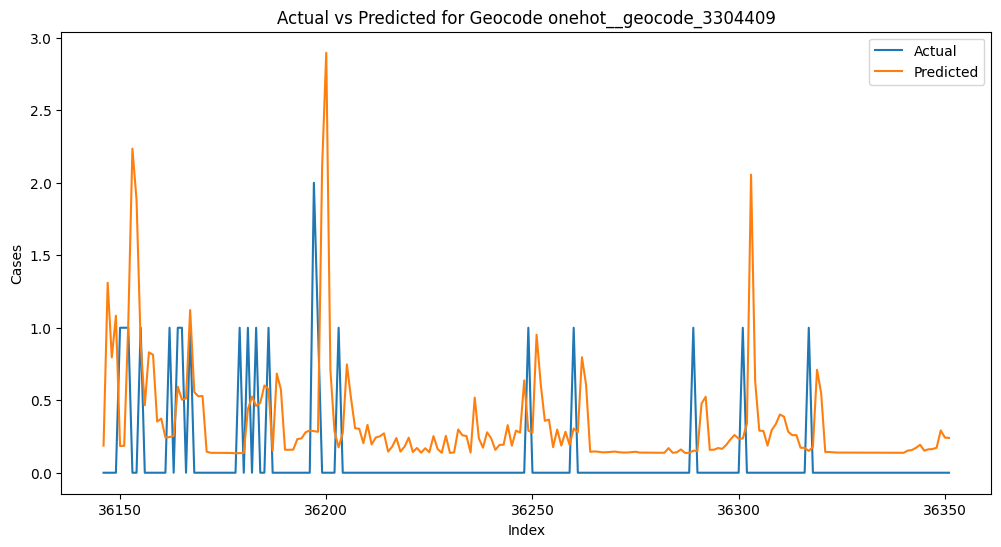

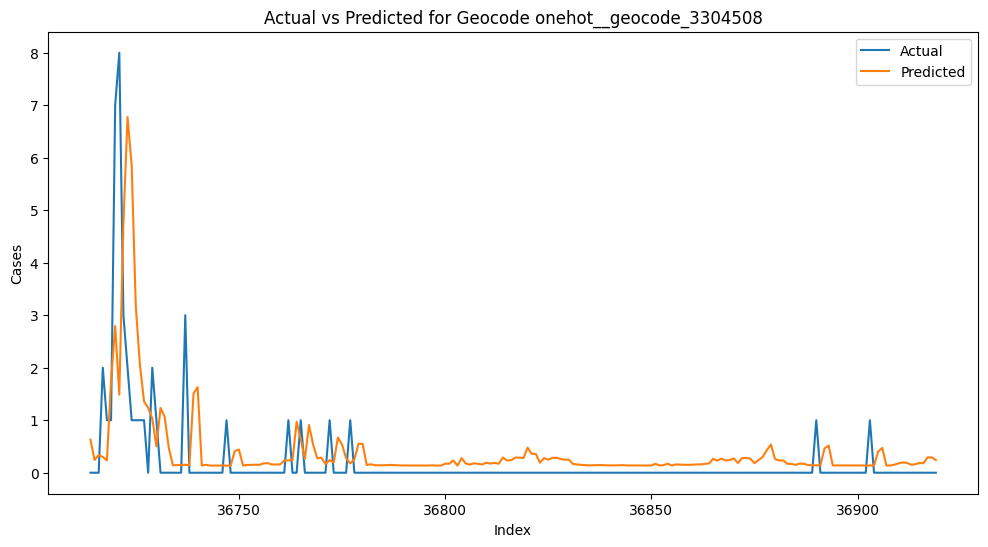

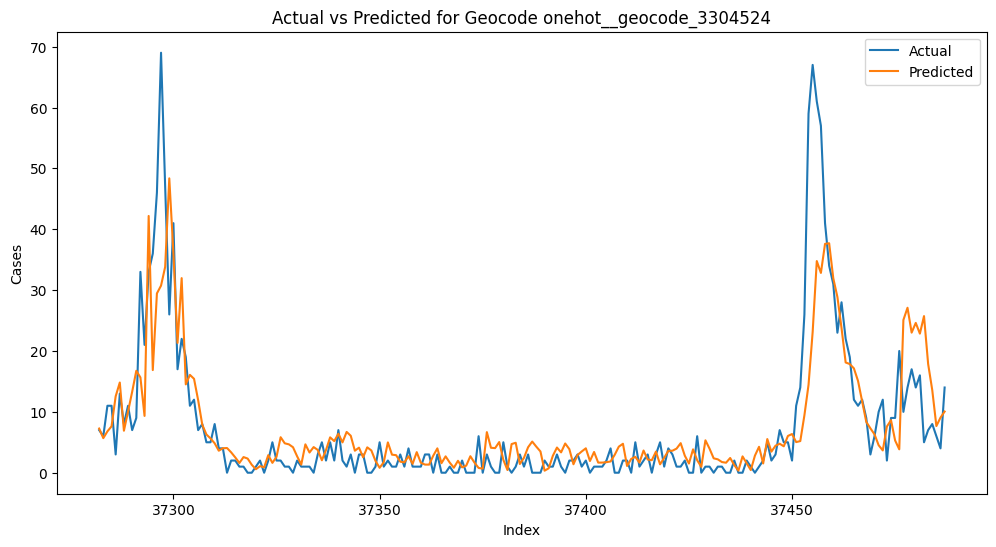

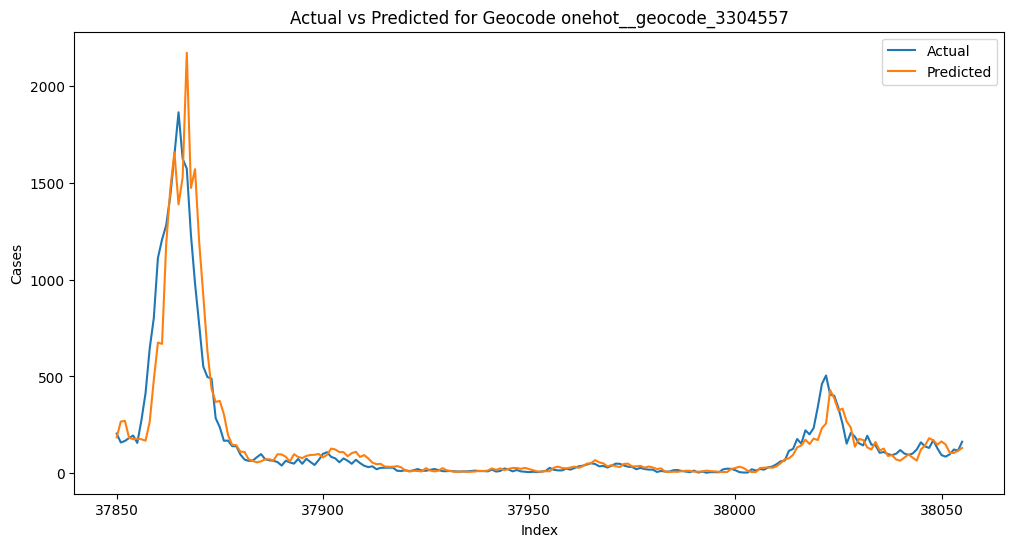

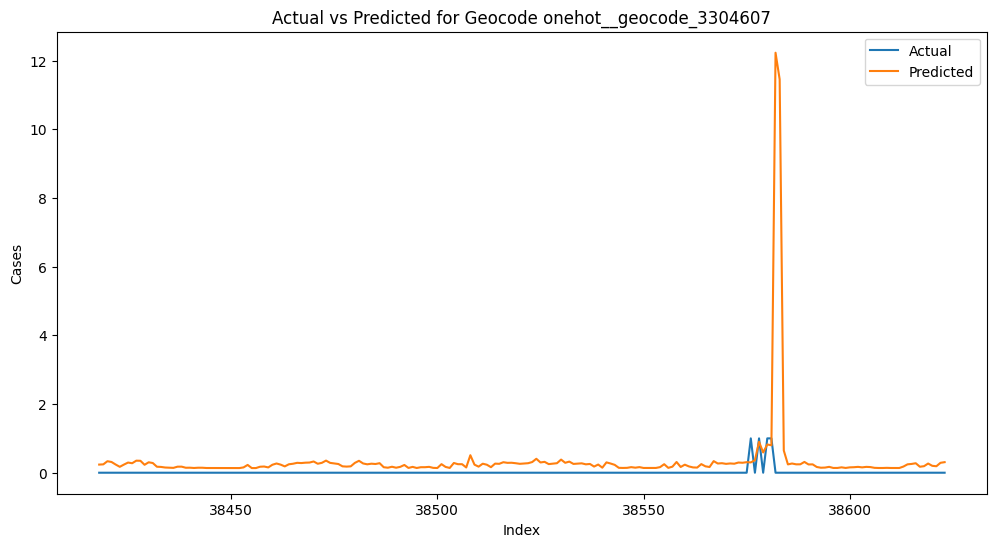

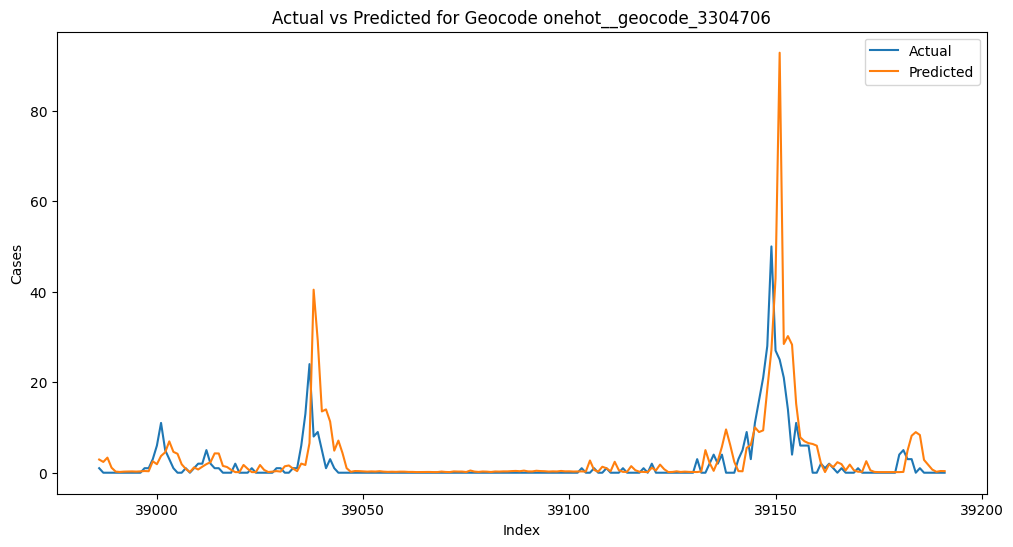

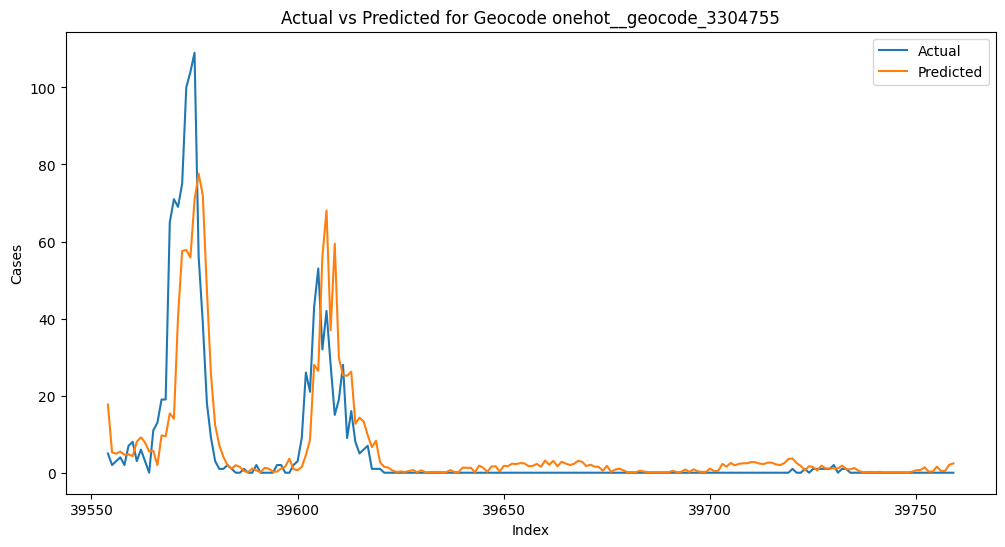

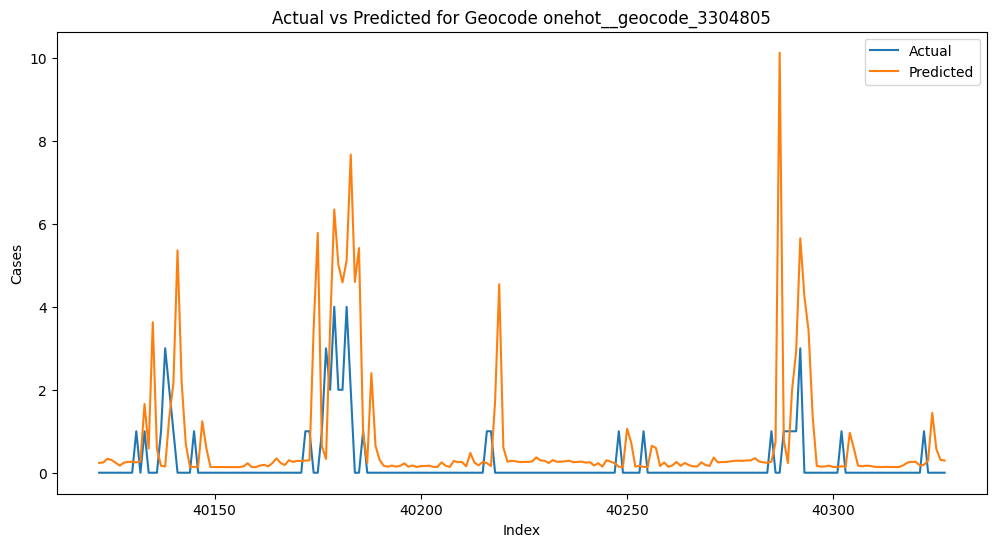

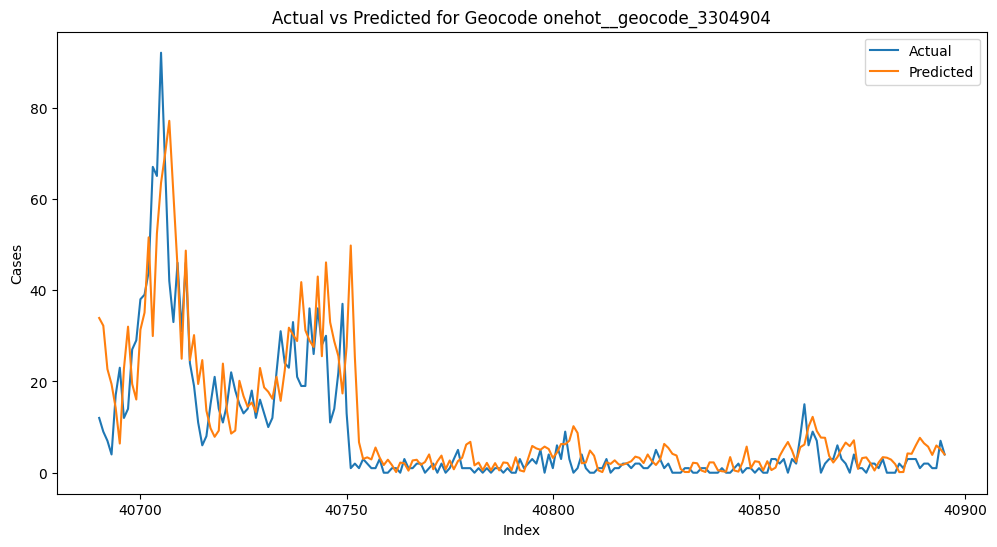

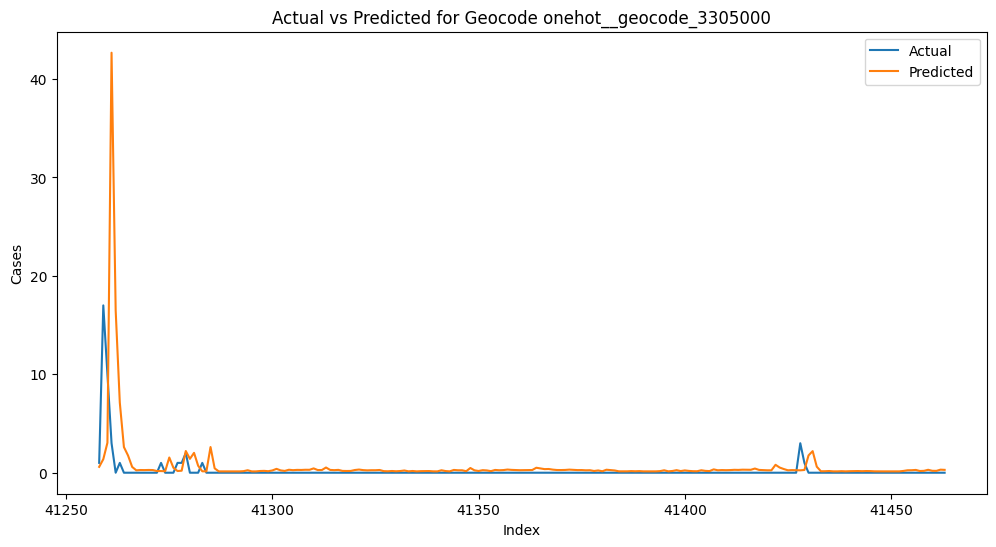

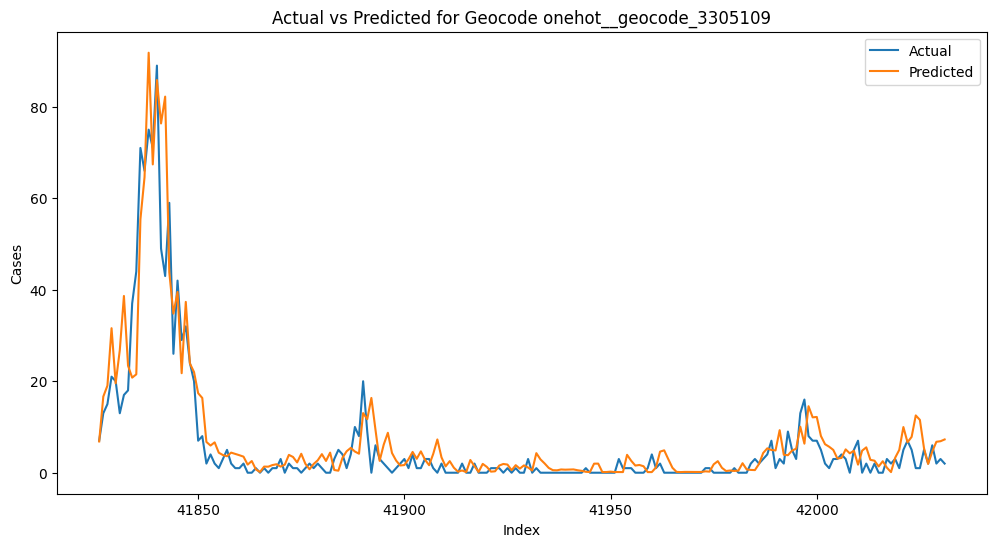

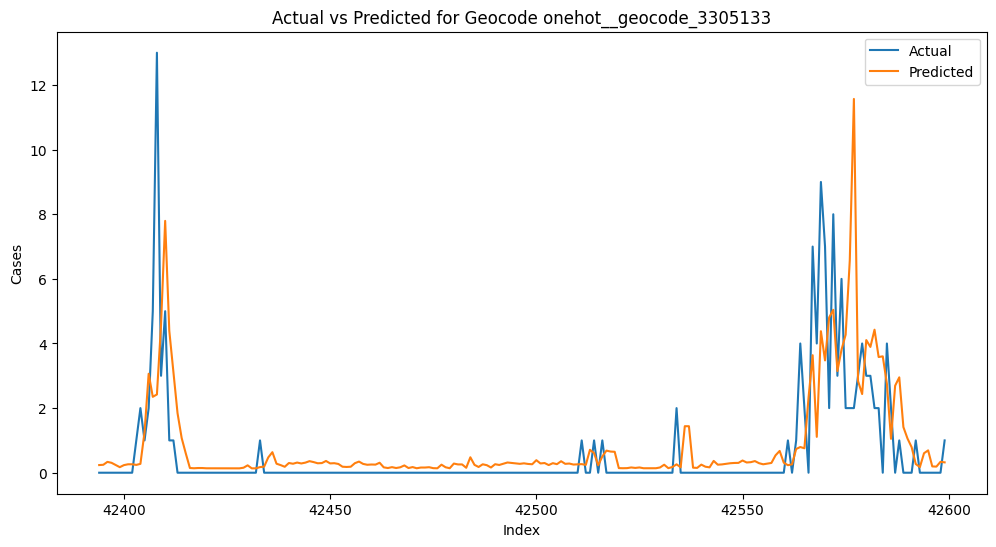

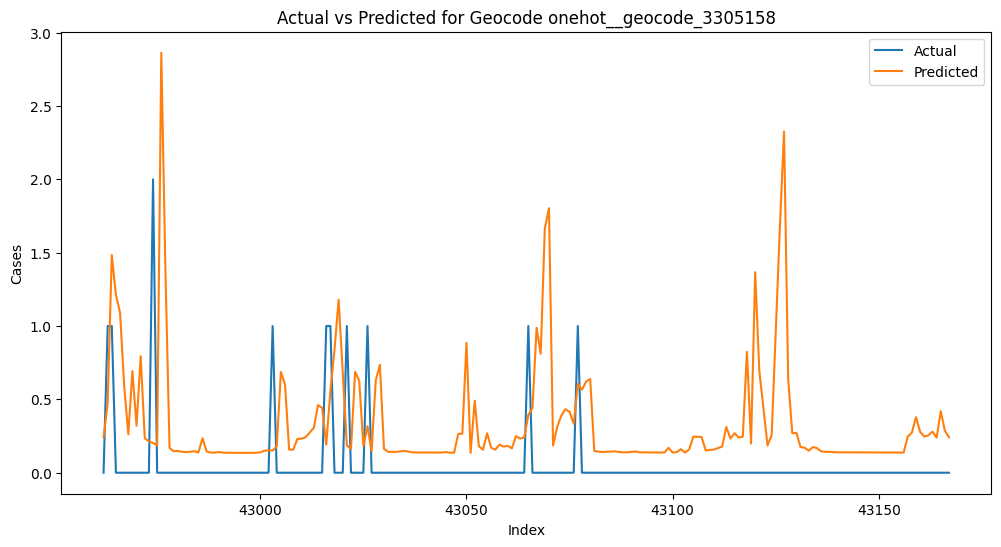

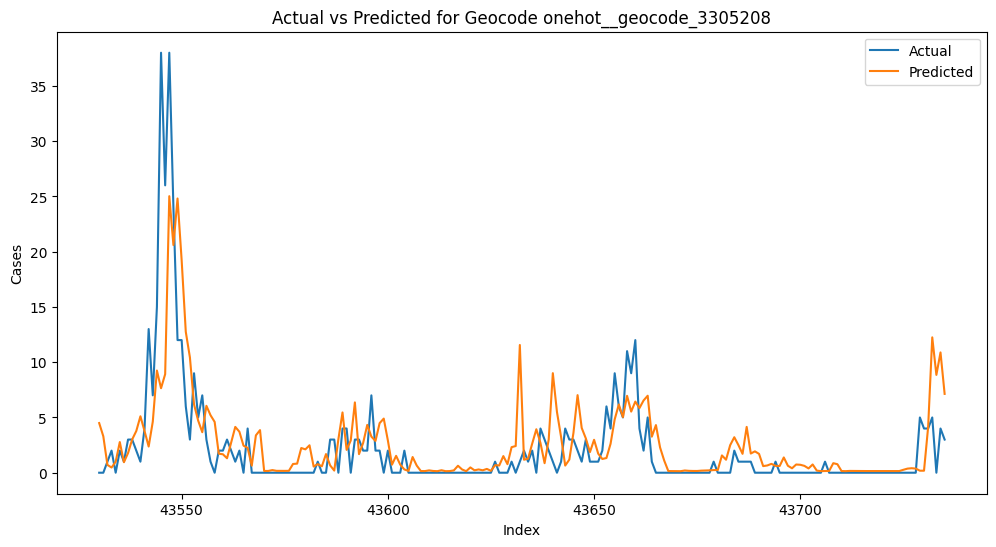

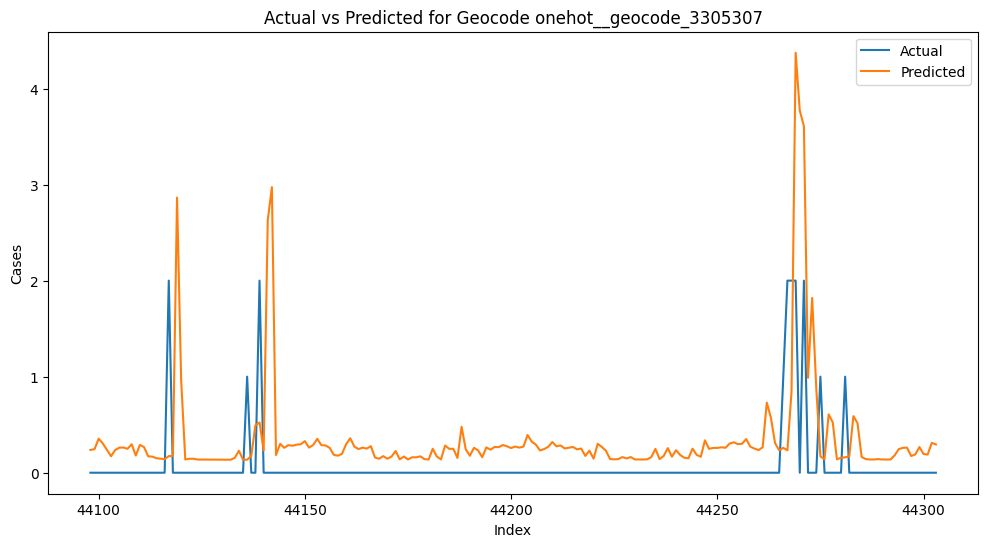

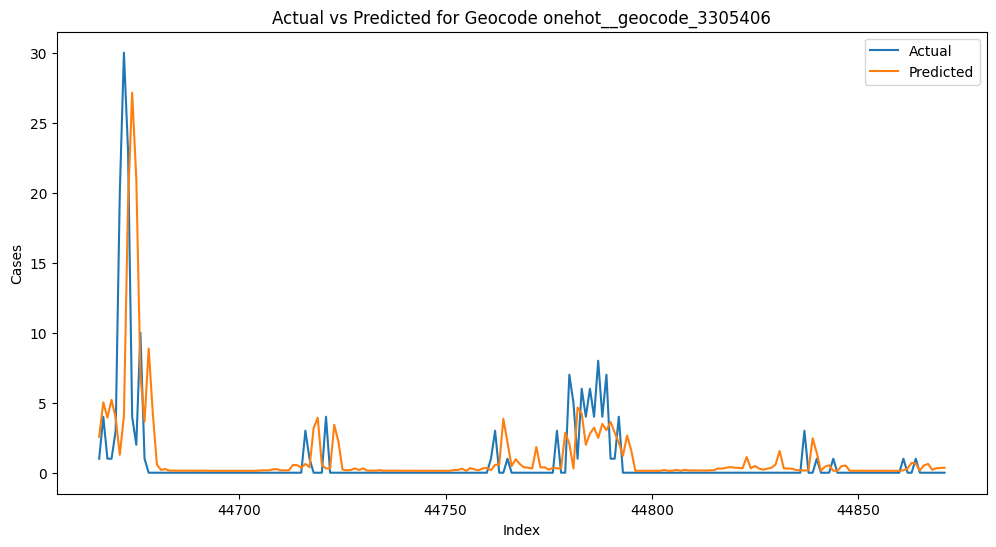

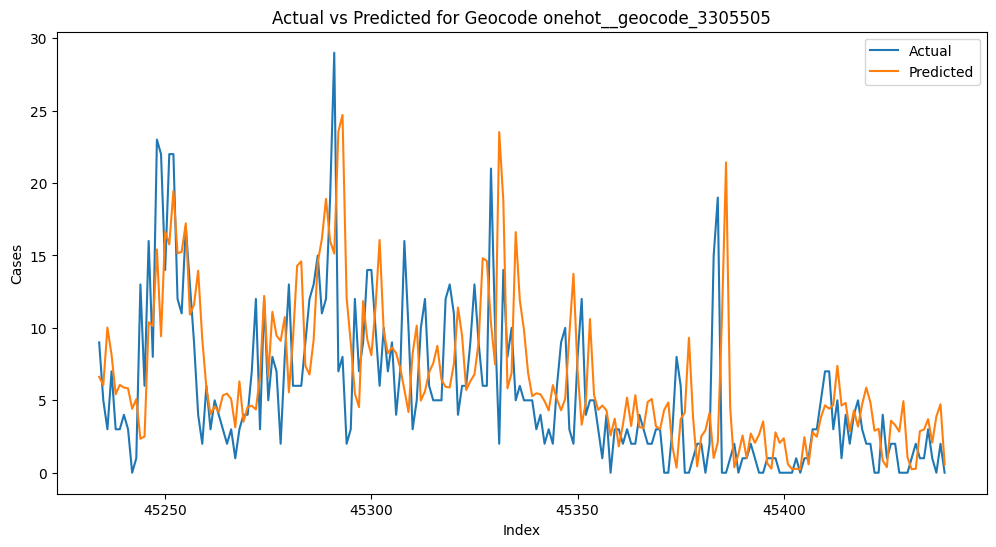

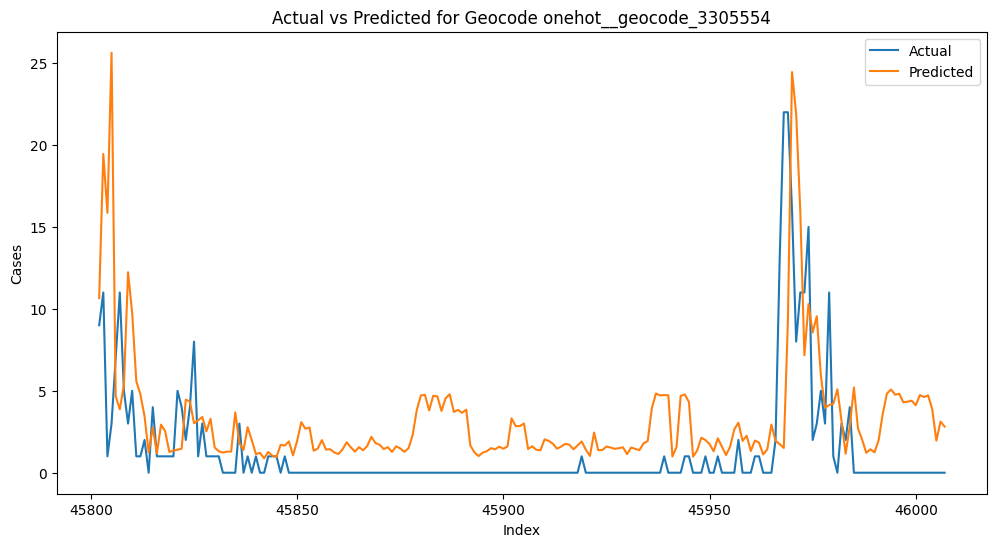

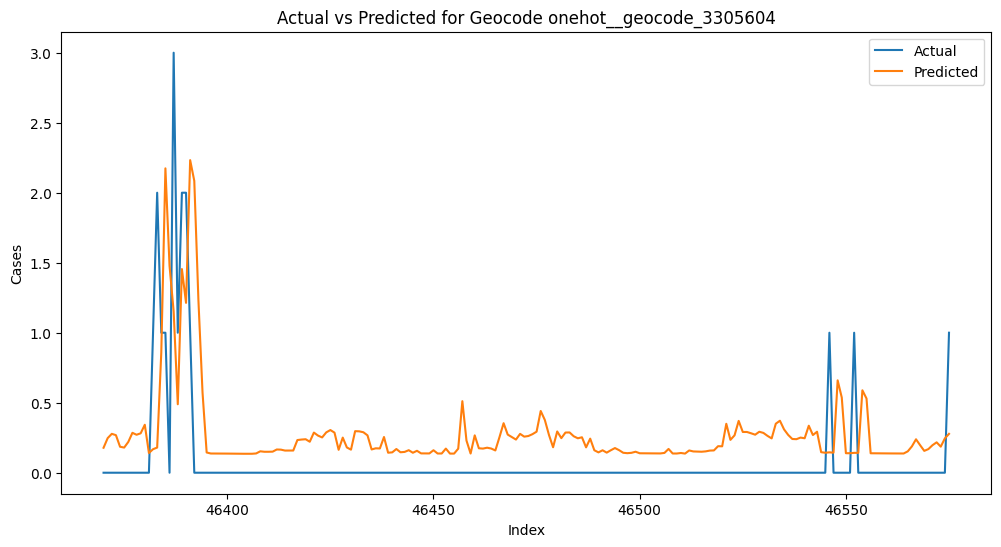

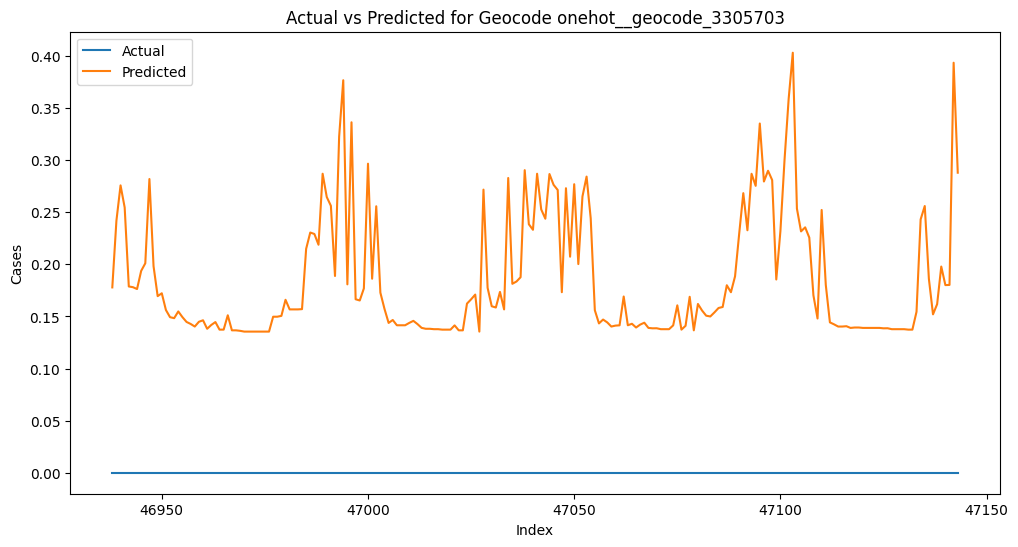

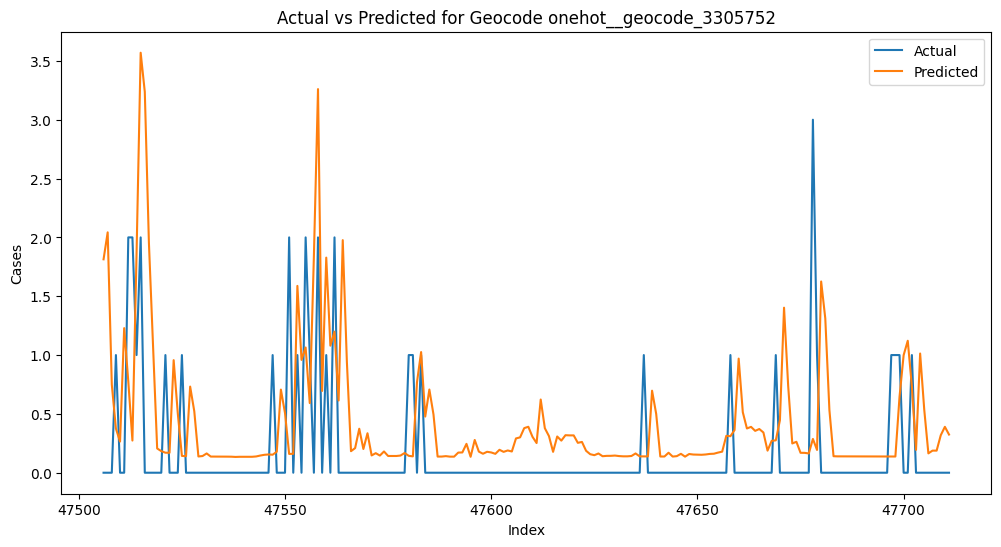

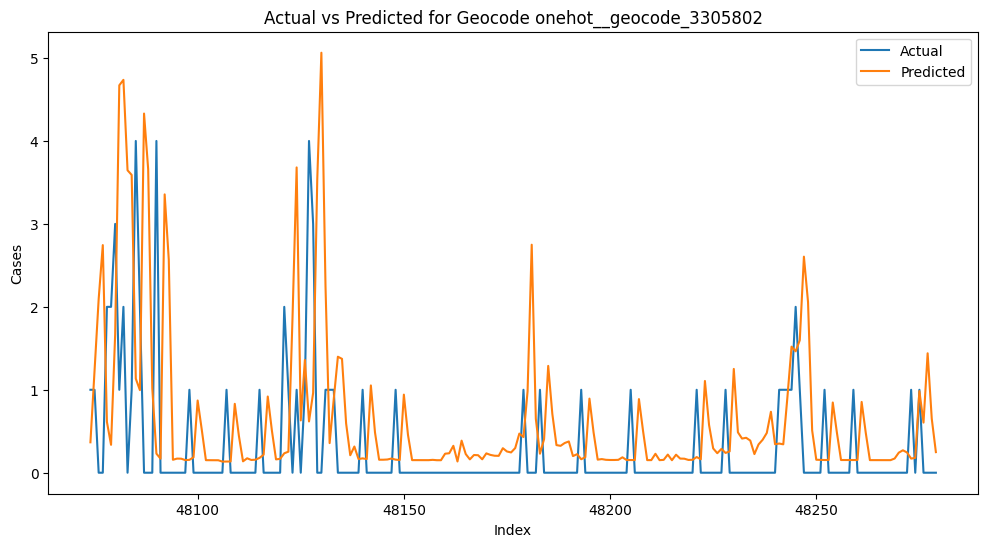

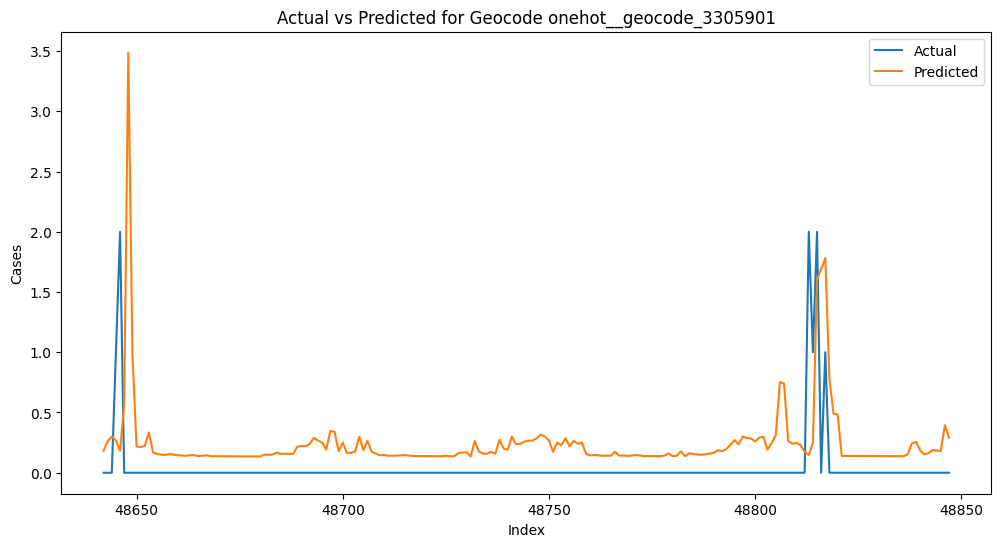

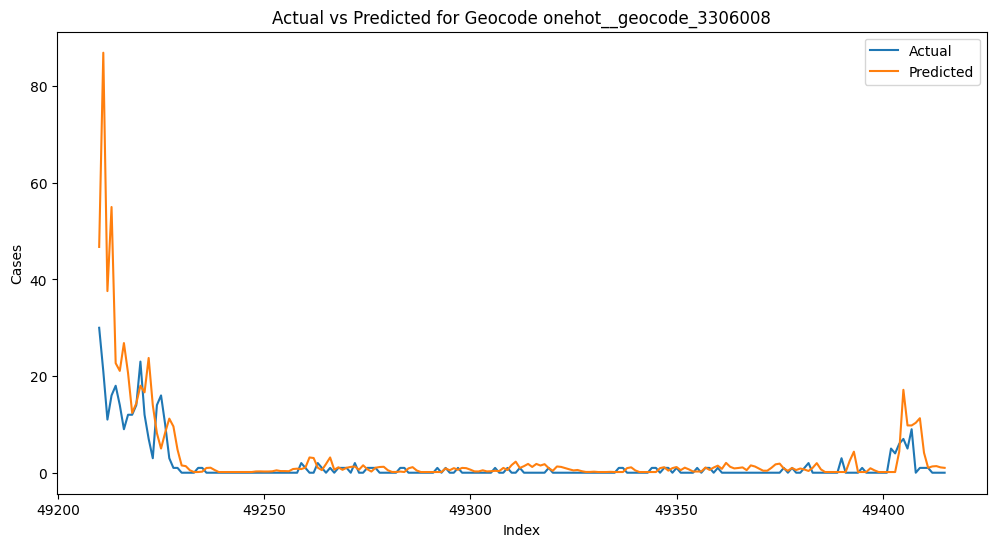

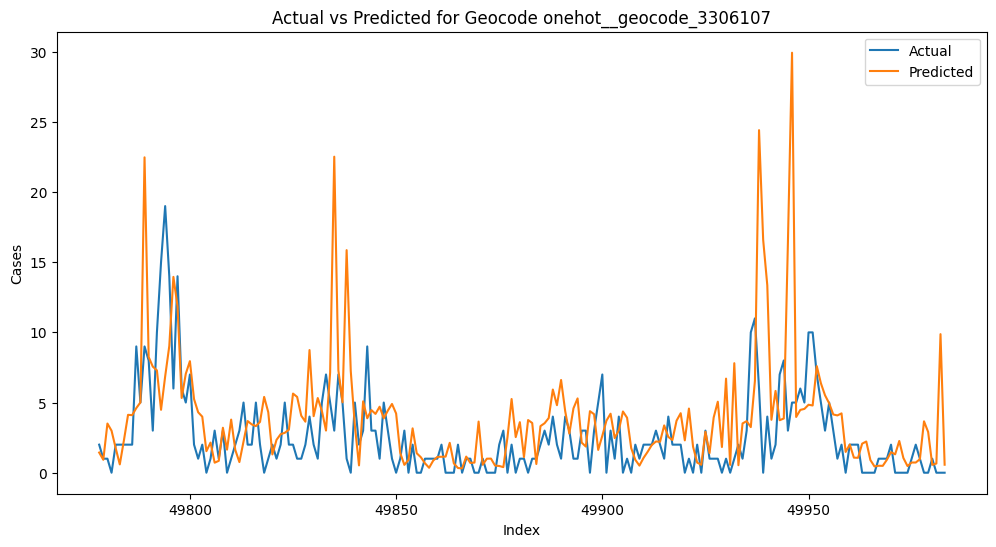

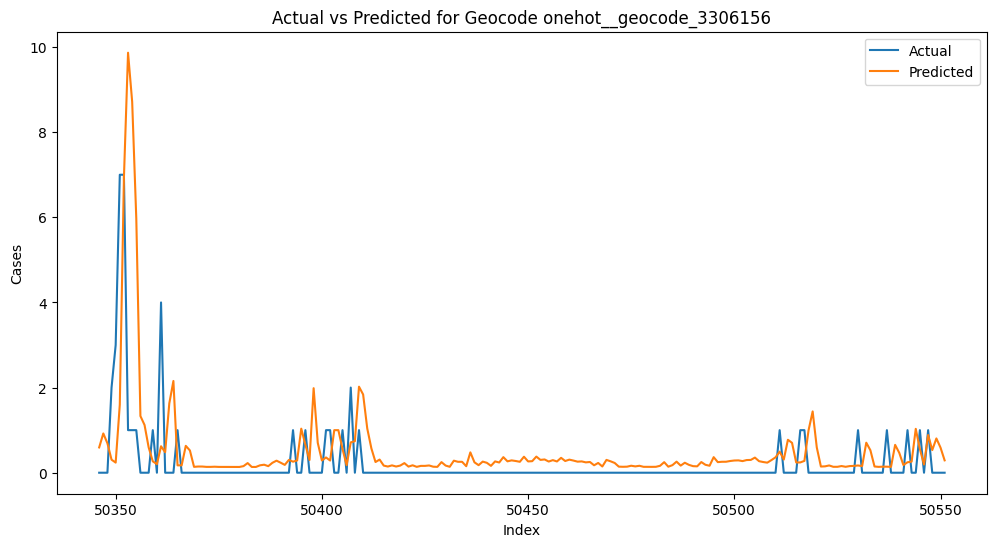

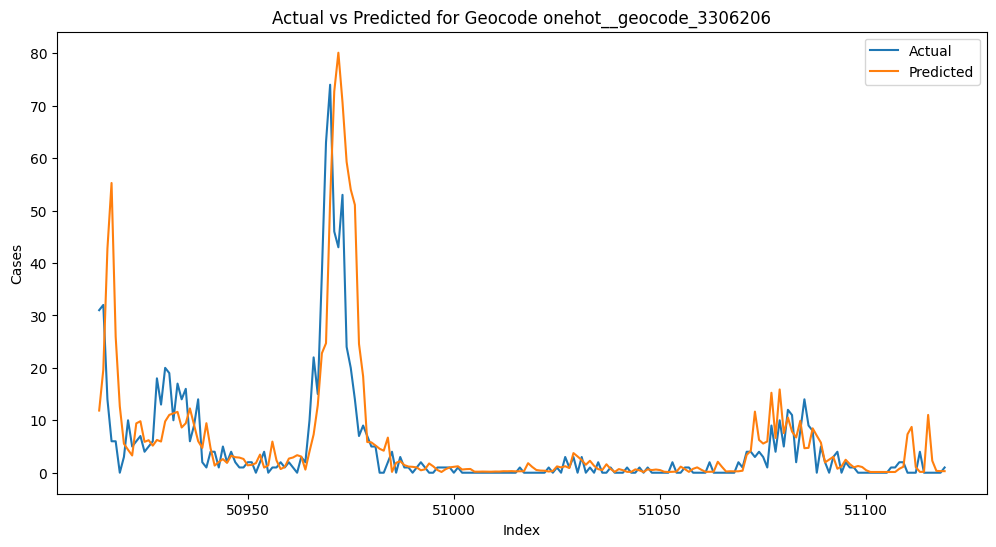

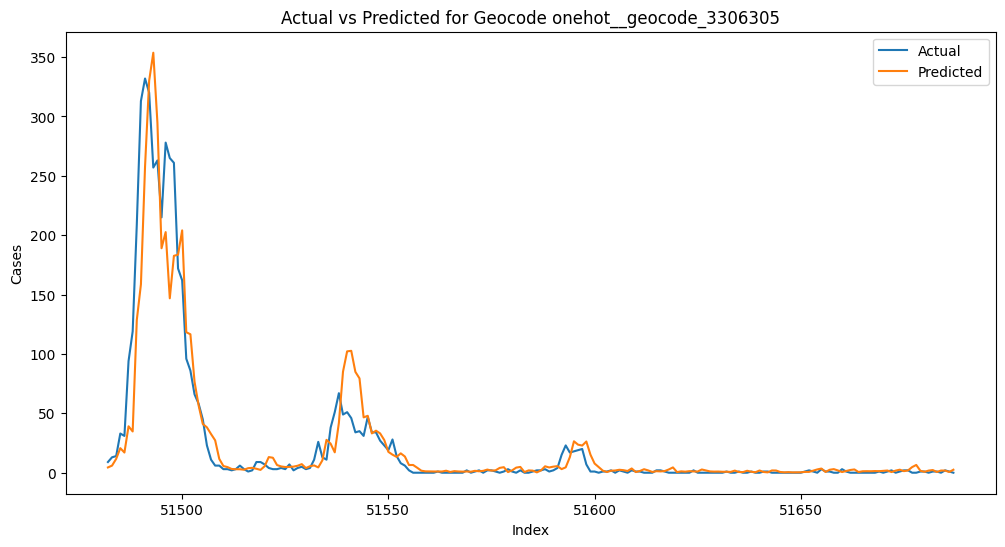

In [6]:
# Define parameter grid for Random Forest
# grid_params = {
#     'n_estimators': [50],
#     'max_depth': [20],
#     'min_samples_split': [10],
#     'min_samples_leaf': [4]
# }

grid_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(rf, grid_params, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train_scaled)

best_model = grid_search.best_estimator_

# Predictions
y_train_pred_scaled = best_model.predict(X_train)
y_test_pred_scaled = best_model.predict(X_test)

y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()
y_train_original = target_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).ravel()
y_test_original = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred))
train_r2 = r2_score(y_train_original, y_train_pred)
test_r2 = r2_score(y_test_original, y_test_pred)

mae = mean_absolute_error(y_test_original, y_test_pred)
mape = mean_absolute_percentage_error(y_test_original, y_test_pred)

# Print best parameters and metrics
print("Best Random Forest Parameters:", grid_search.best_params_)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R²:", train_r2)
print("Test R²:", test_r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100, "%")

# Feature Importance
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

# Prepare test dataframe with results
X_test_df = pd.DataFrame(X_test, columns=selected_columns)
X_test_df["actual"] = y_test_original
X_test_df["predicted"] = y_test_pred

# Plot Actual vs Predicted for each one-hot encoded geocode column
for geocode in X_test_df.columns:
    if geocode.startswith('onehot__geocode_'):
        subset = X_test_df[X_test_df[geocode] == 1]
        plt.figure(figsize=(12, 6))
        plt.plot(subset.index, subset["actual"], label='Actual')
        plt.plot(subset.index, subset["predicted"], label='Predicted')
        plt.xlabel("Index")
        plt.ylabel("Cases")
        plt.title(f"Actual vs Predicted for Geocode {geocode}")
        plt.legend()
        plt.show()


In [7]:
# Make a copy of the test DataFrame
X_test_full = X_test.copy()

# --- Step 1: Reconstruct geocode from one-hot encoded columns
geocode_cols = [col for col in X_test_full.columns if col.startswith("onehot__geocode_")]

# Extract the geocode number from the column name where the value is 1
def extract_geocode(row):
    for col in geocode_cols:
        if row[col] == 1:
            return col.split("_")[-1]  # Gets '3300100' from 'onehot__geocode_3300100'
    return None
X_test_full['geocode'] = X_test_full[geocode_cols].apply(extract_geocode, axis=1)
# Drop all onehot columns
onehot_cols = [col for col in X_test_full.columns if col.startswith("onehot")]
X_test_full.drop(columns=onehot_cols, inplace=True)

X_test_full

cases_lag0  cases_lag1  temp_avg  humidity_avg  \
362      0.000612    0.000408  0.593139      0.786243   
363      0.000544    0.000612  0.776641      0.536203   
364      0.000204    0.000544  0.790603      0.541574   
365      0.000476    0.000204  0.934213      0.271575   
366      0.000272    0.000476  0.615689      0.702061   
...           ...         ...       ...           ...   
51683    0.000000    0.000068  0.651481      0.667016   
51684    0.000068    0.000000  0.652021      0.710028   
51685    0.000068    0.000068  0.732835      0.720982   
51686    0.000000    0.000068  0.705427      0.677245   
51687    0.000136    0.000000  0.691546      0.666338   

       precipitation_avg_ordinary_kriging_lag3  \
362                                   0.121655   
363                                   0.333885   
364                                   0.572009   
365                                   0.007637   
366                                   0.062353   
...                                        ...   
51683                                 0.200626   
51684                                 0.340947   
51685                                 0.305778   
51686                                 0.194017   
51687                                 0.283354   

       precipitation_avg_ordinary_kriging_lag4  week_sin     month_sin  \
362                                   0.023069 -0.992709  5.000000e-01   
363                                   0.121655 -1.000000  5.000000e-01   
364                                   0.333885 -0.992709  5.000000e-01   
365                                   0.572009 -0.970942  5.000000e-01   
366                                   0.007637 -0.935016  8.660254e-01   
...                                        ...       ...           ...   
51683                                 0.098343  0.822984 -5.000000e-01   
51684                                 0.200626  0.748511 -5.000000e-01   
51685                                 0.340947  0.663123 -5.000000e-01   
51686                                 0.305778  0.568065 -2.449294e-16   
51687                                 0.194017  0.464723 -2.449294e-16   

           week_cos  month_cos    week  cases_per_100k       vim  geocode  
362   -1.205367e-01   0.866025  201902        0.002003  0.974928  3300100  
363   -8.959324e-13   0.866025  201903        0.001781  0.977877  3300100  
364    1.205367e-01   0.866025  201904        0.000668  0.980632  3300100  
365    2.393157e-01   0.866025  201905        0.001558  0.983210  3300100  
366    3.546049e-01   0.500000  201906        0.000890  0.985713  3300100  
...             ...        ...     ...             ...       ...      ...  
51683 -5.680647e-01   0.866025  202246        0.000000  0.625559  3306305  
51684 -6.631227e-01   0.866025  202247        0.000168  0.657550  3306305  
51685 -7.485107e-01   0.866025  202248        0.000168  0.688081  3306305  
51686 -8.229839e-01   1.000000  202249        0.000000  0.716714  3306305  
51687 -8.854560e-01   1.000000  202250        0.000336  0.741960  3306305  

[18746 rows x 14 columns]

In [8]:
X_test_full['year'] = X_test_full['week'].astype(str).str[:4].astype(int)
X_test_full

cases_lag0  cases_lag1  temp_avg  humidity_avg  \
362      0.000612    0.000408  0.593139      0.786243   
363      0.000544    0.000612  0.776641      0.536203   
364      0.000204    0.000544  0.790603      0.541574   
365      0.000476    0.000204  0.934213      0.271575   
366      0.000272    0.000476  0.615689      0.702061   
...           ...         ...       ...           ...   
51683    0.000000    0.000068  0.651481      0.667016   
51684    0.000068    0.000000  0.652021      0.710028   
51685    0.000068    0.000068  0.732835      0.720982   
51686    0.000000    0.000068  0.705427      0.677245   
51687    0.000136    0.000000  0.691546      0.666338   

       precipitation_avg_ordinary_kriging_lag3  \
362                                   0.121655   
363                                   0.333885   
364                                   0.572009   
365                                   0.007637   
366                                   0.062353   
...                                        ...   
51683                                 0.200626   
51684                                 0.340947   
51685                                 0.305778   
51686                                 0.194017   
51687                                 0.283354   

       precipitation_avg_ordinary_kriging_lag4  week_sin     month_sin  \
362                                   0.023069 -0.992709  5.000000e-01   
363                                   0.121655 -1.000000  5.000000e-01   
364                                   0.333885 -0.992709  5.000000e-01   
365                                   0.572009 -0.970942  5.000000e-01   
366                                   0.007637 -0.935016  8.660254e-01   
...                                        ...       ...           ...   
51683                                 0.098343  0.822984 -5.000000e-01   
51684                                 0.200626  0.748511 -5.000000e-01   
51685                                 0.340947  0.663123 -5.000000e-01   
51686                                 0.305778  0.568065 -2.449294e-16   
51687                                 0.194017  0.464723 -2.449294e-16   

           week_cos  month_cos    week  cases_per_100k       vim  geocode  \
362   -1.205367e-01   0.866025  201902        0.002003  0.974928  3300100   
363   -8.959324e-13   0.866025  201903        0.001781  0.977877  3300100   
364    1.205367e-01   0.866025  201904        0.000668  0.980632  3300100   
365    2.393157e-01   0.866025  201905        0.001558  0.983210  3300100   
366    3.546049e-01   0.500000  201906        0.000890  0.985713  3300100   
...             ...        ...     ...             ...       ...      ...   
51683 -5.680647e-01   0.866025  202246        0.000000  0.625559  3306305   
51684 -6.631227e-01   0.866025  202247        0.000168  0.657550  3306305   
51685 -7.485107e-01   0.866025  202248        0.000168  0.688081  3306305   
51686 -8.229839e-01   1.000000  202249        0.000000  0.716714  3306305   
51687 -8.854560e-01   1.000000  202250        0.000336  0.741960  3306305   

       year  
362    2019  
363    2019  
364    2019  
365    2019  
366    2019  
...     ...  
51683  2022  
51684  2022  
51685  2022  
51686  2022  
51687  2022  

[18746 rows x 15 columns]

In [10]:

# Add actual and predicted values
X_test_full['actual'] = y_test_original
X_test_full['rf_pred'] = y_test_pred

# Export predictions by year
rf_preds_2019 = X_test_full[X_test_full['year'] == 2019][['geocode', 'week', 'rf_pred', 'actual']]
rf_preds_2019.to_csv('rf_test_preds_2019.csv', index=False)

rf_preds_2020 = X_test_full[X_test_full['year'] == 2020][['geocode', 'week', 'rf_pred', 'actual']]
rf_preds_2020.to_csv('rf_test_preds_2020.csv', index=False)

# Export predictions by year
rf_preds_2021 = X_test_full[X_test_full['year'] == 2021][['geocode', 'week', 'rf_pred', 'actual']]
rf_preds_2021.to_csv('rf_test_preds_2021.csv', index=False)

rf_preds_2022 = X_test_full[X_test_full['year'] == 2022][['geocode', 'week', 'rf_pred', 'actual']]
rf_preds_2022.to_csv('rf_test_preds_2022.csv', index=False)